In [21]:
import sklearn as skl
import pickle as pkl
import pandas as pd
import numpy as np

import sklearn.model_selection
import sklearn.svm
import sklearn.metrics

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import seaborn as sns

from itertools import chain

In [22]:
import scipy as sp

In [23]:
import math
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

In [24]:
import sys
sys.path.append("..") # or wherever the package is
import kuanglu

In [25]:
import scanpy as sc

In [26]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

## Exp 1: simple FF for embedding

In [27]:
adata = sc.read_h5ad('data/demo1_sp_adata.h5ad')

train_Xs = []
chosen_slices = ['MsBrainAgingSpatialDonor_5_0', 'MsBrainAgingSpatialDonor_6_0', 
                 'MsBrainAgingSpatialDonor_7_0']
for i in chosen_slices:
    train_Xs.append(np.array(adata.X[adata.obs['donor_slice'] == i, :]))
    
validate_Xs = []
chosen_donors = ['MsBrainAgingSpatialDonor_8_0']
for i in chosen_donors:
    validate_Xs.append(np.array(adata.X[adata.obs['donor_slice'] == i, :]))
    
_, p = train_Xs[0].shape

class MyDataSet(Data.Dataset):
    def __init__(self, Xs):
        super(MyDataSet, self).__init__()
        self.Xs = [torch.Tensor(X) for X in Xs]
        
    def __len__(self):
        return len(self.Xs)

    def __getitem__(self, idx):
        return self.Xs[idx]

train_data = MyDataSet(train_Xs)
train_loader = Data.DataLoader(train_data, batch_size=1, shuffle=True) 

print("Training data dimensions:")
for i in train_Xs:
    print(i.shape)

validate_data = MyDataSet(validate_Xs)
validate_loader = Data.DataLoader(validate_data, batch_size=1, shuffle=True)

print("Validation data dimensions:")
for i in validate_Xs:
    print(i.shape)

Training data dimensions:
(5000, 374)
(5000, 374)
(5000, 374)
Validation data dimensions:
(5000, 374)


In [28]:
embed_config = {
    'embedType': 'ff',
    'ldim': [p, 512, 256, 128],
}

model = kuanglu.Model(d_gene=p, 
                      d_denoise = [p], 
                      d_quality=[512, 256, 1], 
                      lbd=1.,
                      embed_config=embed_config,
                      ).to('cuda')

In [29]:
rec = model.fit('denoised', train_loader, validate_loader, [0, 500],
                fix=['embed', 'qualify', 'smooth', 'interact'], lr=1e-4)

Epoch 0001 Train MSE 0.984 Validate MSE 0.988 Raw MSE 0.965
Epoch 0002 Train MSE 0.962 Validate MSE 1.006 Raw MSE 0.988
Epoch 0003 Train MSE 0.964 Validate MSE 1.045 Raw MSE 1.028
Epoch 0004 Train MSE 0.972 Validate MSE 1.031 Raw MSE 1.009


/home/caoyufan/kuanglu/examples/../kuanglu/model.py:312: UserWarning: Parameter containing:
tensor(100., device='cuda:0') is already fixed. They will be unfixed when exiting this function.
  warnings.warn(f"{param} is already fixed. They will be unfixed when exiting this function.")


Epoch 0005 Train MSE 0.978 Validate MSE 1.015 Raw MSE 0.994
Epoch 0006 Train MSE 0.964 Validate MSE 0.993 Raw MSE 0.972
Epoch 0007 Train MSE 0.958 Validate MSE 0.998 Raw MSE 0.979
Epoch 0008 Train MSE 0.959 Validate MSE 1.057 Raw MSE 1.040
Epoch 0009 Train MSE 0.973 Validate MSE 1.059 Raw MSE 1.038
Epoch 0010 Train MSE 0.962 Validate MSE 1.024 Raw MSE 1.001
Epoch 0011 Train MSE 0.959 Validate MSE 1.039 Raw MSE 1.019
Epoch 0012 Train MSE 0.952 Validate MSE 1.012 Raw MSE 0.993
Epoch 0013 Train MSE 0.984 Validate MSE 1.044 Raw MSE 1.022
Epoch 0014 Train MSE 0.958 Validate MSE 1.035 Raw MSE 1.015
Epoch 0015 Train MSE 0.948 Validate MSE 1.050 Raw MSE 1.026
Epoch 0016 Train MSE 0.950 Validate MSE 1.051 Raw MSE 1.029
Epoch 0017 Train MSE 0.950 Validate MSE 1.033 Raw MSE 1.011
Epoch 0018 Train MSE 0.953 Validate MSE 1.076 Raw MSE 1.055


Epoch 0019 Train MSE 0.944 Validate MSE 1.027 Raw MSE 1.006
Epoch 0020 Train MSE 0.954 Validate MSE 1.016 Raw MSE 0.995
Epoch 0021 Train MSE 0.954 Validate MSE 1.013 Raw MSE 0.991
Epoch 0022 Train MSE 0.938 Validate MSE 1.001 Raw MSE 0.978
Epoch 0023 Train MSE 0.948 Validate MSE 1.035 Raw MSE 1.010
Epoch 0024 Train MSE 0.936 Validate MSE 0.999 Raw MSE 0.979
Epoch 0025 Train MSE 0.949 Validate MSE 1.022 Raw MSE 1.001
Epoch 0026 Train MSE 0.951 Validate MSE 1.032 Raw MSE 1.013
Epoch 0027 Train MSE 0.935 Validate MSE 1.049 Raw MSE 1.027
Epoch 0028 Train MSE 0.946 Validate MSE 1.040 Raw MSE 1.021
Epoch 0029 Train MSE 0.944 Validate MSE 1.005 Raw MSE 0.990
Epoch 0030 Train MSE 0.958 Validate MSE 1.000 Raw MSE 0.986
Epoch 0031 Train MSE 0.931 Validate MSE 1.039 Raw MSE 1.018
Epoch 0032 Train MSE 0.925 Validate MSE 1.002 Raw MSE 0.985
Epoch 0033 Train MSE 0.937 Validate MSE 1.012 Raw MSE 0.998
Epoch 0034 Train MSE 0.924 Validate MSE 1.030 Raw MSE 1.016
Epoch 0035 Train MSE 0.936 Validate MSE 

In [30]:
rec = kuanglu.record_concat(rec, model.fit('smoothed', train_loader, validate_loader, [500, 750],
                                           fix=['denoise', 'interact'], lr=1e-4))
rec = kuanglu.record_concat(rec, model.fit('smoothed', train_loader, validate_loader, [750, 1000],
                                           fix=['interact'], lr=1e-4))

Epoch 0501 Train MSE 0.957 Validate MSE 1.008 Raw MSE 1.026
Epoch 0502 Train MSE 0.934 Validate MSE 0.997 Raw MSE 1.028
Epoch 0503 Train MSE 0.914 Validate MSE 0.986 Raw MSE 1.014
Epoch 0504 Train MSE 0.902 Validate MSE 0.965 Raw MSE 1.011
Epoch 0505 Train MSE 0.906 Validate MSE 0.985 Raw MSE 1.038


Epoch 0506 Train MSE 0.895 Validate MSE 0.962 Raw MSE 1.013
Epoch 0507 Train MSE 0.893 Validate MSE 0.950 Raw MSE 1.014
Epoch 0508 Train MSE 0.877 Validate MSE 0.937 Raw MSE 1.004
Epoch 0509 Train MSE 0.887 Validate MSE 0.950 Raw MSE 0.993
Epoch 0510 Train MSE 0.879 Validate MSE 0.930 Raw MSE 1.000
Epoch 0511 Train MSE 0.857 Validate MSE 0.941 Raw MSE 1.007
Epoch 0512 Train MSE 0.881 Validate MSE 0.935 Raw MSE 1.013
Epoch 0513 Train MSE 0.866 Validate MSE 0.931 Raw MSE 1.005
Epoch 0514 Train MSE 0.860 Validate MSE 0.906 Raw MSE 0.992
Epoch 0515 Train MSE 0.871 Validate MSE 0.906 Raw MSE 1.003
Epoch 0516 Train MSE 0.851 Validate MSE 0.942 Raw MSE 1.008
Epoch 0517 Train MSE 0.852 Validate MSE 0.907 Raw MSE 0.989
Epoch 0518 Train MSE 0.843 Validate MSE 0.922 Raw MSE 1.009
Epoch 0519 Train MSE 0.849 Validate MSE 0.941 Raw MSE 1.031
Epoch 0520 Train MSE 0.867 Validate MSE 0.924 Raw MSE 1.021
Epoch 0521 Train MSE 0.850 Validate MSE 0.935 Raw MSE 1.026
Epoch 0522 Train MSE 0.838 Validate MSE 

In [31]:
rec = kuanglu.record_concat(rec, model.fit('final', train_loader, validate_loader, [1000, 1250],
                                           fix=['denoise', 'embed', 'qualify', 'smooth'], lr=1e-4))
rec = kuanglu.record_concat(rec, model.fit('final', train_loader, validate_loader, [1250, 1500], lr=1e-4))

Epoch 1001 Train MSE 0.811 Validate MSE 0.891 Raw MSE 1.006
Epoch 1002 Train MSE 0.835 Validate MSE 0.871 Raw MSE 0.989
Epoch 1003 Train MSE 0.821 Validate MSE 0.895 Raw MSE 1.013
Epoch 1004 Train MSE 0.827 Validate MSE 0.879 Raw MSE 1.005
Epoch 1005 Train MSE 0.838 Validate MSE 0.900 Raw MSE 1.006


Epoch 1006 Train MSE 0.832 Validate MSE 0.884 Raw MSE 0.999
Epoch 1007 Train MSE 0.825 Validate MSE 0.885 Raw MSE 1.006
Epoch 1008 Train MSE 0.832 Validate MSE 0.868 Raw MSE 0.985
Epoch 1009 Train MSE 0.833 Validate MSE 0.905 Raw MSE 1.033
Epoch 1010 Train MSE 0.817 Validate MSE 0.887 Raw MSE 1.008
Epoch 1011 Train MSE 0.824 Validate MSE 0.877 Raw MSE 0.998
Epoch 1012 Train MSE 0.826 Validate MSE 0.910 Raw MSE 1.035
Epoch 1013 Train MSE 0.831 Validate MSE 0.905 Raw MSE 1.030
Epoch 1014 Train MSE 0.822 Validate MSE 0.915 Raw MSE 1.024
Epoch 1015 Train MSE 0.839 Validate MSE 0.844 Raw MSE 0.972
Epoch 1016 Train MSE 0.823 Validate MSE 0.891 Raw MSE 1.028
Epoch 1017 Train MSE 0.814 Validate MSE 0.893 Raw MSE 1.006
Epoch 1018 Train MSE 0.834 Validate MSE 0.873 Raw MSE 0.994
Epoch 1019 Train MSE 0.831 Validate MSE 0.895 Raw MSE 1.010
Epoch 1020 Train MSE 0.835 Validate MSE 0.888 Raw MSE 1.018
Epoch 1021 Train MSE 0.827 Validate MSE 0.893 Raw MSE 1.014
Epoch 1022 Train MSE 0.811 Validate MSE 

Text(0, 0.5, 'MSE')

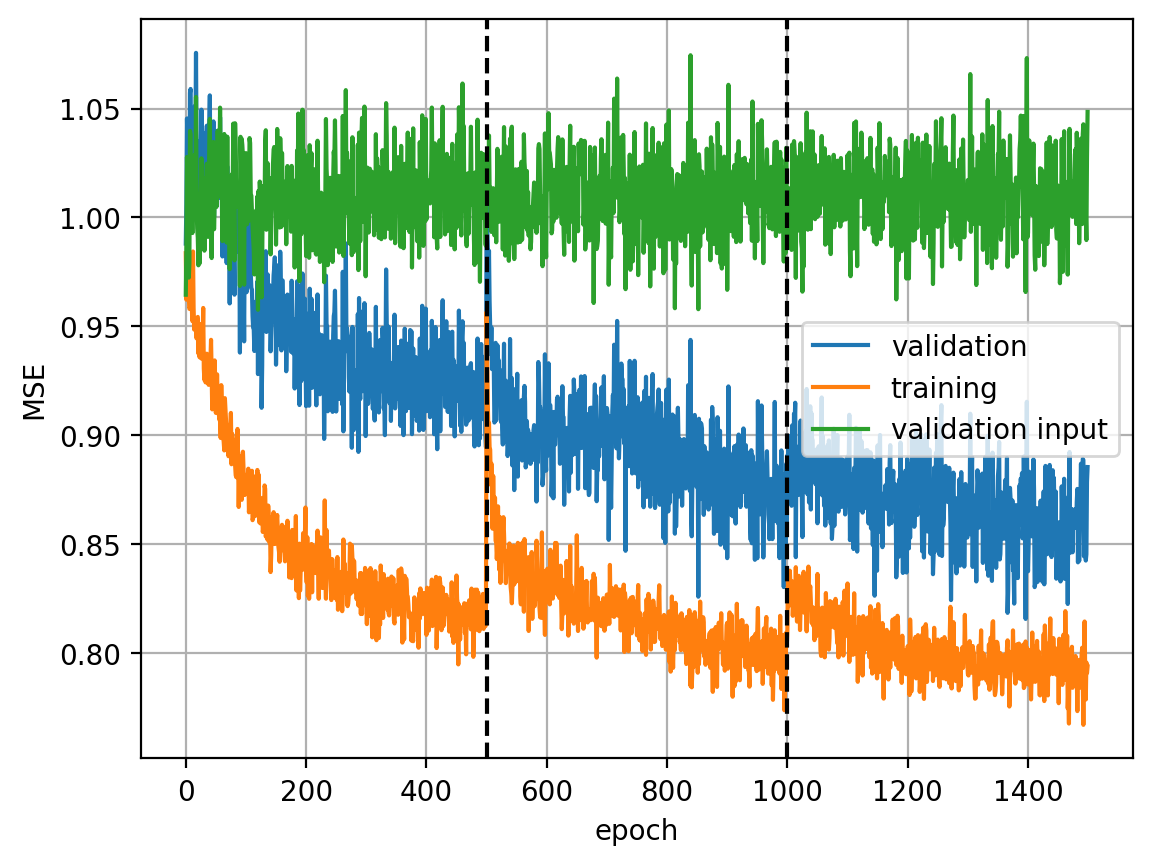

In [32]:
plt.plot(rec['validate_epoch'], rec['validate_mse'], label='validation')
plt.plot(rec['train_epoch'], rec['train_mse'], label='training')
plt.plot(rec['validate_epoch'], rec['raw_mse'], label='validation input')
plt.legend()
plt.grid()
plt.axvline(500, ls='--', c='k')
plt.axvline(1000, ls='--', c='k')
plt.xlabel('epoch')
plt.ylabel('MSE')

In [33]:
mse_df = pd.DataFrame({'epoch': rec['validate_epoch'], 'mse': rec['validate_mse']})

def epoch2stage(x):
    if x < 250: return 'pre-denoise'
    elif x < 500: return 'denoise'
    elif x < 750: return 'pre-denoise-smooth'
    elif x < 1000: return 'denoise-smooth'
    elif x < 1250: return 'pre-denoise-smooth-enhance'
    elif x < 1500: return 'denoise-smooth-enhance'
    else: raise NotImplementedError('x >= 1500 not allowed')

mse_df['stage'] = mse_df['epoch'].apply(epoch2stage)
mse_df

epoch       mse                   stage
0         0  0.987997             pre-denoise
1         1  1.005834             pre-denoise
2         2  1.045428             pre-denoise
3         3  1.030870             pre-denoise
4         4  1.015015             pre-denoise
...     ...       ...                     ...
1495   1495  0.876645  denoise-smooth-enhance
1496   1496  0.842464  denoise-smooth-enhance
1497   1497  0.845361  denoise-smooth-enhance
1498   1498  0.878584  denoise-smooth-enhance
1499   1499  0.885396  denoise-smooth-enhance

[1500 rows x 3 columns]

/home/caoyufan/miniconda3/envs/kuanglu/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/caoyufan/miniconda3/envs/kuanglu/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/caoyufan/miniconda3/envs/kuanglu/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


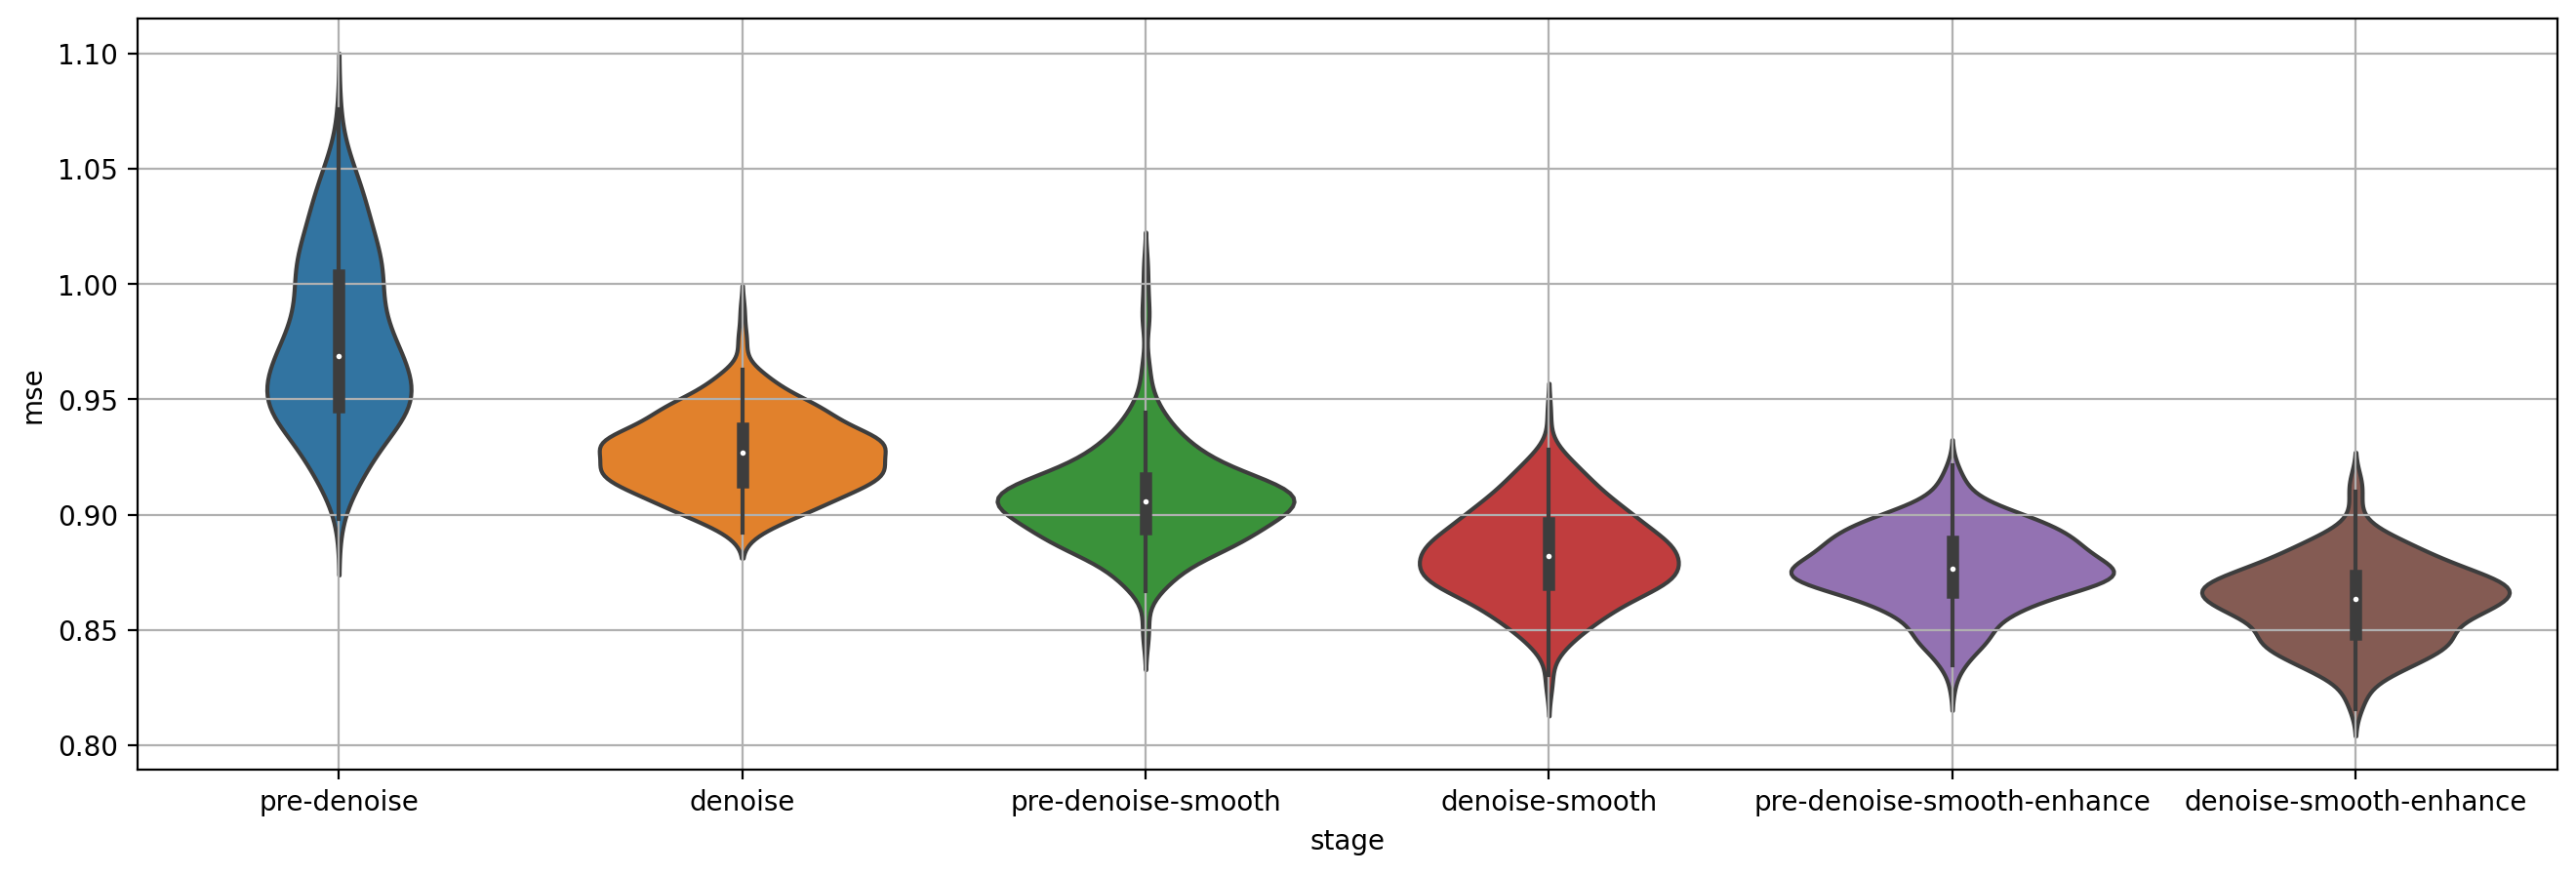

In [34]:
# sns.violinplot(mse_df[~mse_df['stage'].str.contains('pre-')], x='stage', y='mse')
%config InlineBackend.figure_format ='retina'
plt.figure(figsize=(16, 5))
sns.violinplot(mse_df, x='stage', y='mse')
plt.grid()

In [35]:
u_stat, p_val = sp.stats.mannwhitneyu(mse_df.loc[mse_df['stage'] == 'denoise', 'mse'], 
                      mse_df.loc[mse_df['stage'] == 'denoise-smooth', 'mse'])

print('p =', p_val, 
      'f =', u_stat / sum(mse_df['stage'] == 'denoise') / sum(mse_df['stage'] == 'denoise-smooth'))

p = 5.632359996368662e-69 f = 0.95368


In [36]:
u_stat, p_val = sp.stats.mannwhitneyu(mse_df.loc[mse_df['stage'] == 'denoise-smooth', 'mse'], 
                      mse_df.loc[mse_df['stage'] == 'denoise-smooth-enhance', 'mse'])
print('p =', p_val, 
      'f =', u_stat / sum(mse_df['stage'] == 'denoise-smooth') / sum(mse_df['stage'] == 'denoise-smooth-enhance'))

p = 3.9119823941264607e-28 f = 0.784256


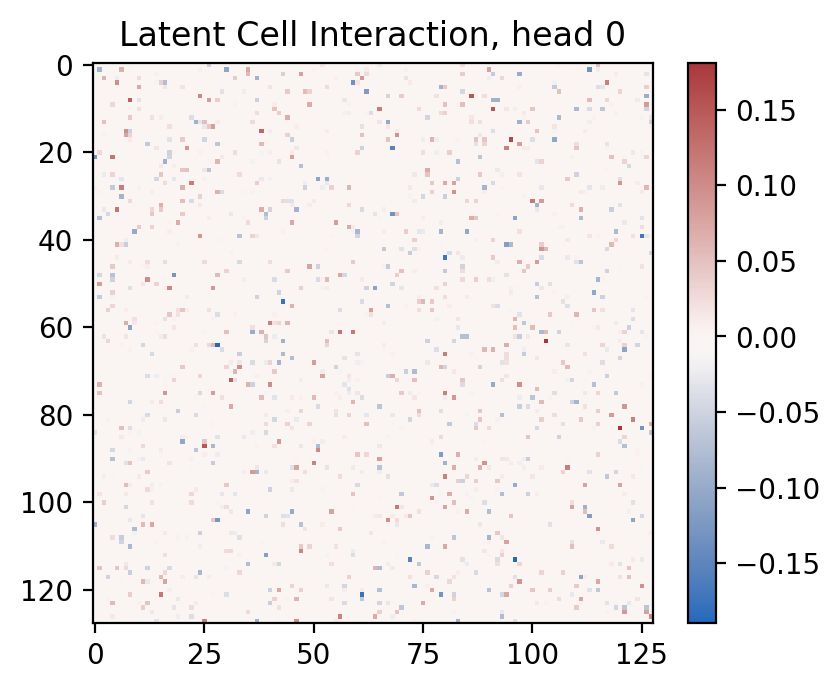

In [37]:
# Plot heatmap of the parameters in cell interaction module

weight_CIs = []
for head in range(len(model.cell_interacts)):
    weight_CIs.append(model.cell_interacts[head].transform.data)

plt.figure(figsize=(10, 8))
for i, weight_CI in enumerate(weight_CIs):
    weight_array = weight_CI.cpu().numpy()
    plt.subplot(2, 2, i + 1)
    plt.imshow(weight_array, cmap='vlag')
    plt.colorbar()
    plt.title(f'Latent Cell Interaction, head {i}')
plt.show()

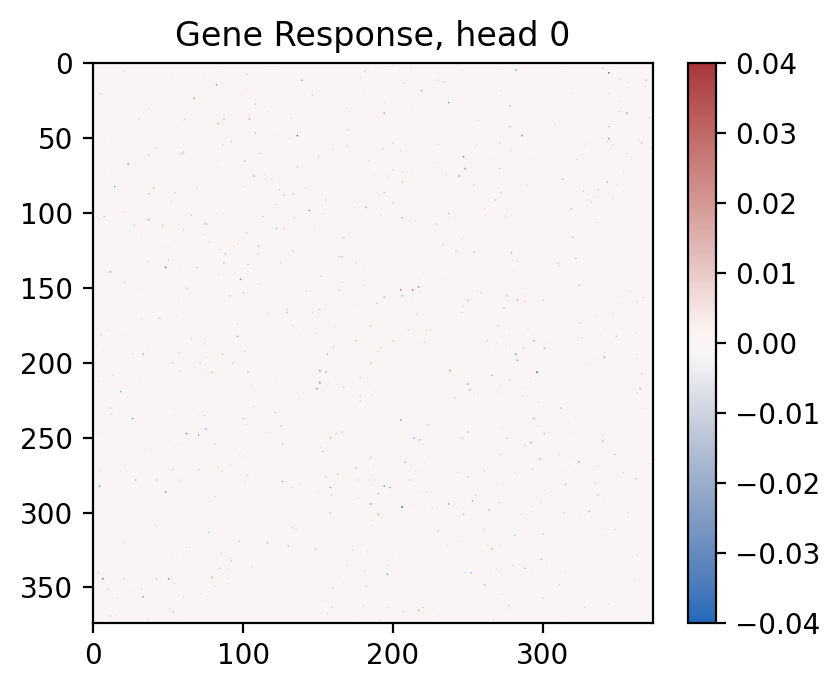

In [38]:
# Plot heatmap of the parameters in gene response module

weight_GRs = []
for head in range(len(model.cell_interacts)):
    weight_GRs.append(model.cell_interacts[head].gene_response.data)

plt.figure(figsize=(10, 8))
for i, weight_GR in enumerate(weight_GRs):
    weight_array = weight_GR.cpu().numpy()
    weight_array = (weight_array + weight_array.T) / 2
    plt.subplot(2, 2, i + 1)
    plt.imshow(weight_array, cmap='vlag', vmin=-.04, vmax=.04)
    plt.colorbar()
    plt.title(f'Gene Response, head {i}')
plt.show()

## Visualization

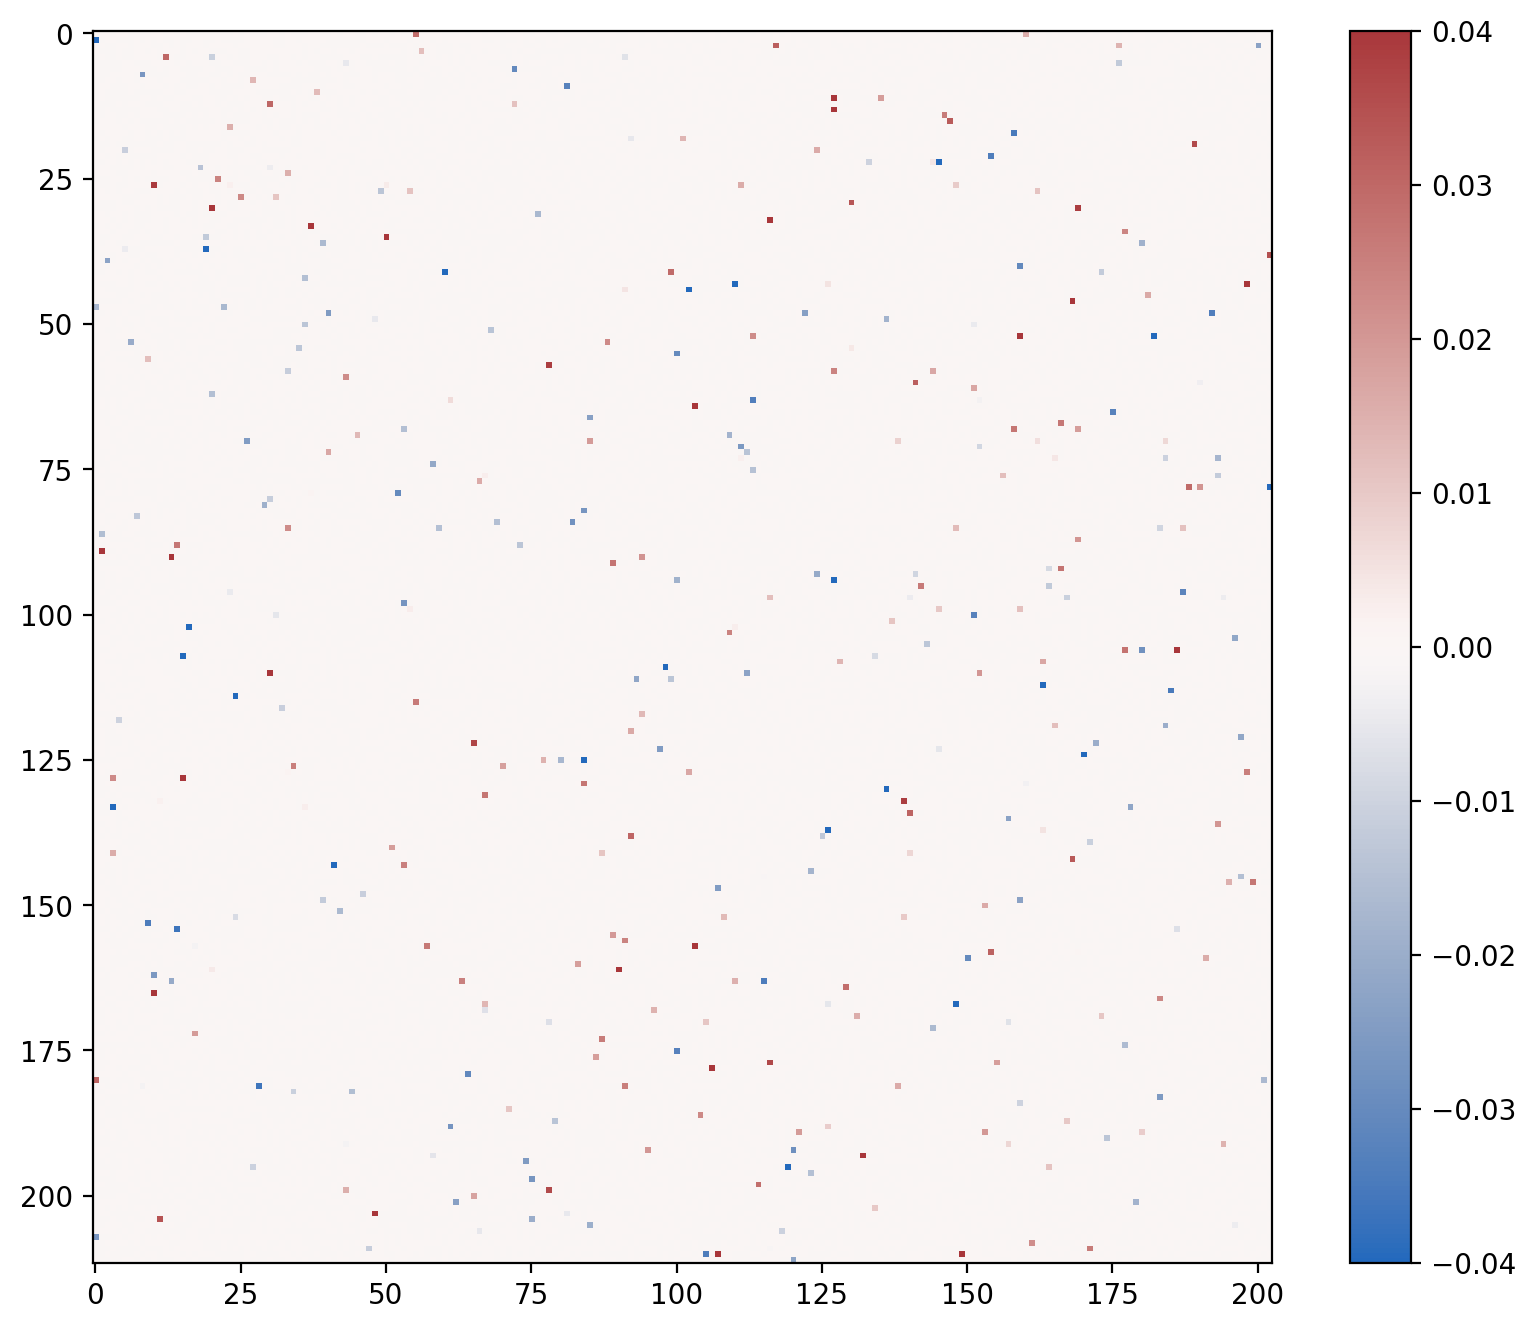

In [19]:
# Extract meaningful weights from Gene Response
THRESHOLD = 0.01

matGR = model.cell_interacts[0].gene_response.data.cpu().numpy()
col_max = np.max(np.abs(matGR), axis=0)
row_max = np.max(np.abs(matGR), axis=1)

meaningfulCols = np.where(col_max > THRESHOLD)[0]
meaningfulRows = np.where(row_max > THRESHOLD)[0]

meaningfulMatGR = matGR[meaningfulRows, :][:, meaningfulCols]

# meaningfulMatGR = np.clip(meaningfulMatGR, -.04, .04)

plt.figure(figsize=(10, 8))
plt.imshow(meaningfulMatGR, cmap='vlag', vmin=-.04, vmax=.04)
plt.colorbar()

In [20]:
# Find the indices of highest absolute values in the meaningfulMatGR

topK = 10
topK_indices = np.argsort(np.abs(matGR), axis=None)[-topK:]

topK_indices = np.unravel_index(topK_indices, matGR.shape)

topK_indices

(array([ 18, 164, 221,  68,  96, 112,  55,  58, 294, 253]),
 array([231,   2, 317,  33, 335, 184,  34,  69,  19,  80]))

In [21]:
np.abs(matGR)[topK_indices]

array([0.06023427, 0.06097675, 0.06174333, 0.06299233, 0.06692594,
       0.06813232, 0.06935076, 0.07503578, 0.0795924 , 0.11085505],
      dtype=float32)

In [22]:
# check the corresponding genes

LR_pairs = []

for i in range(topK):
    LR_pairs.append((adata.var.index[topK_indices[1][i]], 
                     adata.var.index[topK_indices[0][i]]))

LR_pairs

[('ENSMUSG00000063873', 'ENSMUSG00000073418'),
 ('ENSMUSG00000020178', 'ENSMUSG00000038020'),
 ('ENSMUSG00000039410', 'ENSMUSG00000061186'),
 ('ENSMUSG00000073802', 'ENSMUSG00000032446'),
 ('ENSMUSG00000028362', 'ENSMUSG00000078355'),
 ('ENSMUSG00000051910', 'ENSMUSG00000031304'),
 ('ENSMUSG00000032232', 'ENSMUSG00000038642'),
 ('ENSMUSG00000034584', 'ENSMUSG00000034855'),
 ('ENSMUSG00000028222', 'ENSMUSG00000027966'),
 ('ENSMUSG00000026787', 'ENSMUSG00000029814')]

In [23]:
import pandas as pd

lr_pairs = pd.read_csv('./mouse_lr_pair.csv')

lgID = lr_pairs['ligand_ensembl_gene_id']
rpID = lr_pairs['receptor_ensembl_gene_id']

lrID = pd.concat([lgID, rpID], axis=1)
# lrID

geneIDBank = set(adata.var.index)

# filter out the genes that are not in the dataset

lrID = lrID[lrID['ligand_ensembl_gene_id'].isin(geneIDBank) &
            lrID['receptor_ensembl_gene_id'].isin(geneIDBank)]
lrID

ligand_ensembl_gene_id receptor_ensembl_gene_id
26       ENSMUSG00000035385       ENSMUSG00000049103
50       ENSMUSG00000000869       ENSMUSG00000026770
52       ENSMUSG00000000869       ENSMUSG00000031304
275      ENSMUSG00000017344       ENSMUSG00000026768
323      ENSMUSG00000019772       ENSMUSG00000022206
334      ENSMUSG00000019997       ENSMUSG00000020122
339      ENSMUSG00000019997       ENSMUSG00000030786
467      ENSMUSG00000024164       ENSMUSG00000026616
469      ENSMUSG00000024164       ENSMUSG00000030724
470      ENSMUSG00000024164       ENSMUSG00000030786
1144     ENSMUSG00000024164       ENSMUSG00000000290
1153     ENSMUSG00000051439       ENSMUSG00000000290
1212     ENSMUSG00000049796       ENSMUSG00000003476
1296     ENSMUSG00000019772       ENSMUSG00000011171
1356     ENSMUSG00000025746       ENSMUSG00000020122
1357     ENSMUSG00000028364       ENSMUSG00000020122
1473     ENSMUSG00000002985       ENSMUSG00000023992
1557     ENSMUSG00000028364       ENSMUSG00000026768
1653     ENSMUSG00000002985       ENSMUSG00000015243
1900     ENSMUSG00000066551       ENSMUSG00000030786

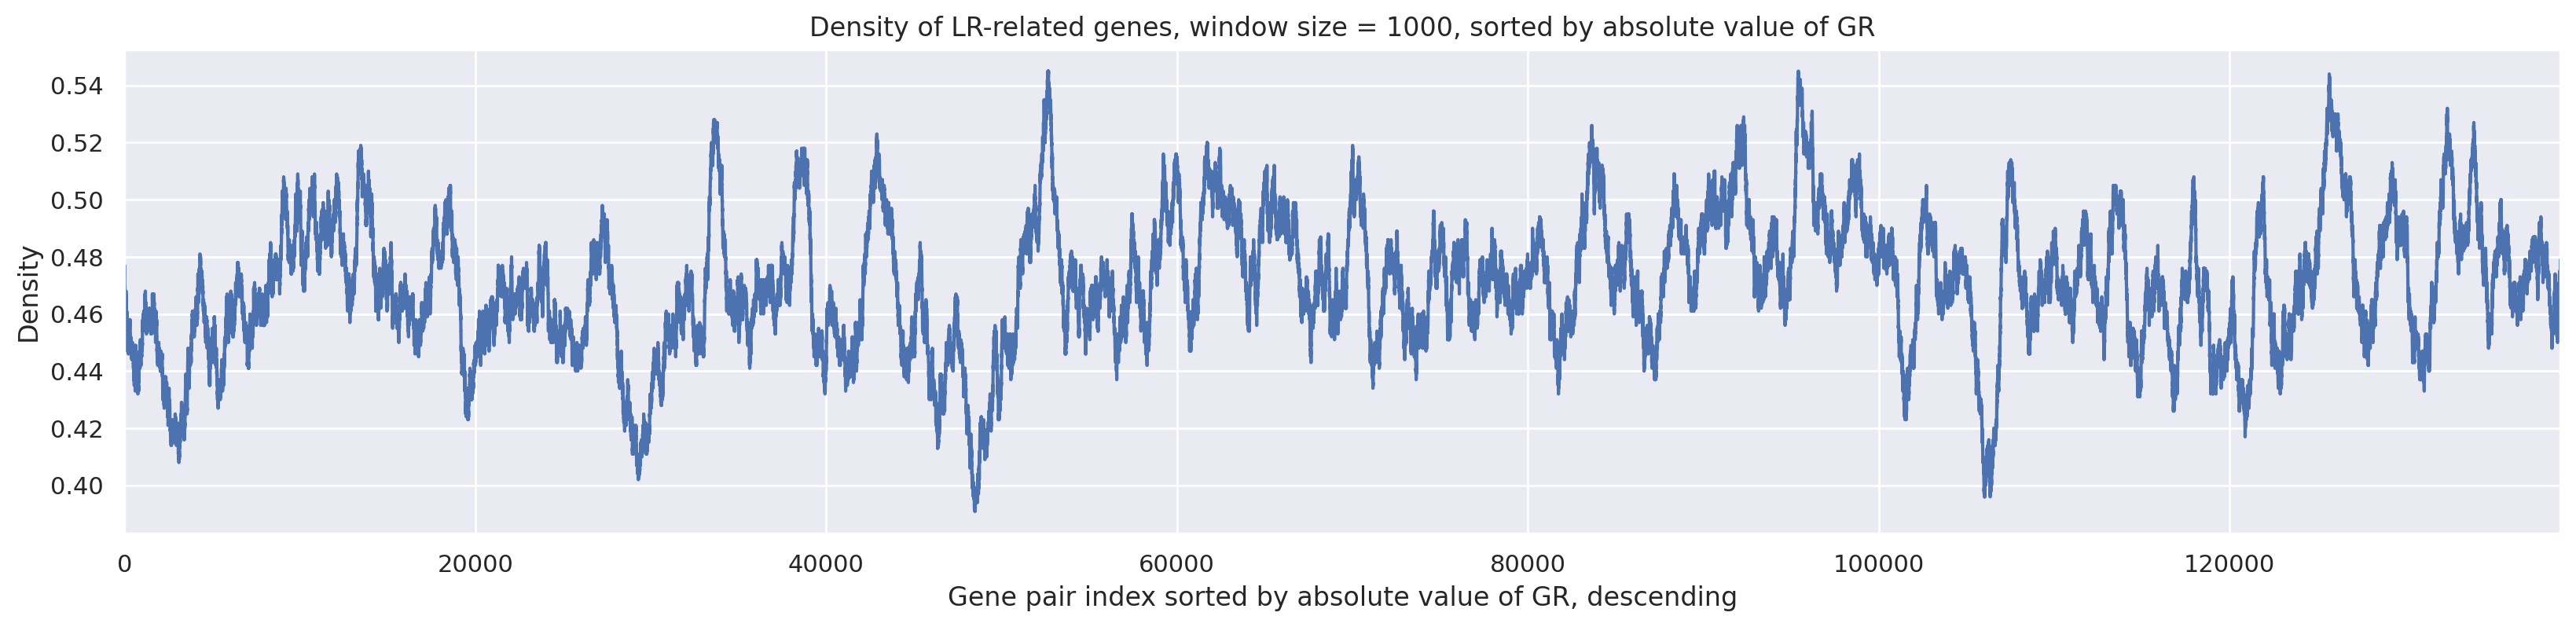

In [24]:
ranked_indices = np.argsort(np.abs(matGR), axis=None)
ranked_indices = np.unravel_index(ranked_indices, matGR.shape)

LR_related_genes = set(lgID) | set(rpID)

hasRelatedGenes = []

for indices in zip(ranked_indices[0], ranked_indices[1]):
    cnt = 0
    if adata.var.index[indices[0]] in LR_related_genes:
        cnt += 1
    if adata.var.index[indices[1]] in LR_related_genes:
        cnt += 1
    hasRelatedGenes.append(cnt)

hasRelatedGenes = np.array(hasRelatedGenes)

WINDOW_SIZE = 1000

density = []

for i in range(len(hasRelatedGenes) - WINDOW_SIZE):
    density.append(np.mean(hasRelatedGenes[i:i + WINDOW_SIZE]))
    
%config InlineBackend.figure_format ='retina'
sns.set()
plt.figure(figsize=(20, 4));
plt.plot(density);
plt.title(f'Density of LR-related genes, window size = {WINDOW_SIZE}, sorted by absolute value of GR');
plt.xlim(0, len(hasRelatedGenes) - WINDOW_SIZE);
plt.xlabel('Gene pair index sorted by absolute value of GR, descending');
plt.ylabel('Density');

In [25]:
genesCol = adata.var_names[meaningfulCols]
genesRow = adata.var_names[meaningfulRows]

genesCol, genesRow

(Index(['ENSMUSG00000035783', 'ENSMUSG00000020178', 'ENSMUSG00000017390',
        'ENSMUSG00000036777', 'ENSMUSG00000038115', 'ENSMUSG00000024411',
        'ENSMUSG00000021835', 'ENSMUSG00000036896', 'ENSMUSG00000045532',
        'ENSMUSG00000073418',
        ...
        'ENSMUSG00000026083', 'ENSMUSG00000055415', 'ENSMUSG00000028370',
        'ENSMUSG00000025357', 'ENSMUSG00000045875', 'ENSMUSG00000055761',
        'ENSMUSG00000040612', 'ENSMUSG00000020160', 'ENSMUSG00000050711',
        'ENSMUSG00000024501'],
       dtype='object', length=203),
 Index(['ENSMUSG00000018381', 'ENSMUSG00000020178', 'ENSMUSG00000017390',
        'ENSMUSG00000036777', 'ENSMUSG00000037010', 'ENSMUSG00000024411',
        'ENSMUSG00000060802', 'ENSMUSG00000048251', 'ENSMUSG00000031375',
        'ENSMUSG00000036887',
        ...
        'ENSMUSG00000055415', 'ENSMUSG00000041959', 'ENSMUSG00000053007',
        'ENSMUSG00000031839', 'ENSMUSG00000025357', 'ENSMUSG00000045875',
        'ENSMUSG00000040612', 'ENSM

In [26]:
meaningfulMatGR.shape

(212, 203)

([<matplotlib.axis.YTick at 0x7f692034ab90>,
 [Text(0, 0, 'ENSMUSG00000061186'),
  Text(0, 1, 'ENSMUSG00000044303'),
  Text(0, 2, 'ENSMUSG00000038679'),
  Text(0, 3, 'ENSMUSG00000026768'),
  Text(0, 4, 'ENSMUSG00000044288'),
  Text(0, 5, 'ENSMUSG00000022708'),
  Text(0, 6, 'ENSMUSG00000027776'),
  Text(0, 7, 'ENSMUSG00000048163'),
  Text(0, 8, 'ENSMUSG00000021750'),
  Text(0, 9, 'ENSMUSG00000019997')])

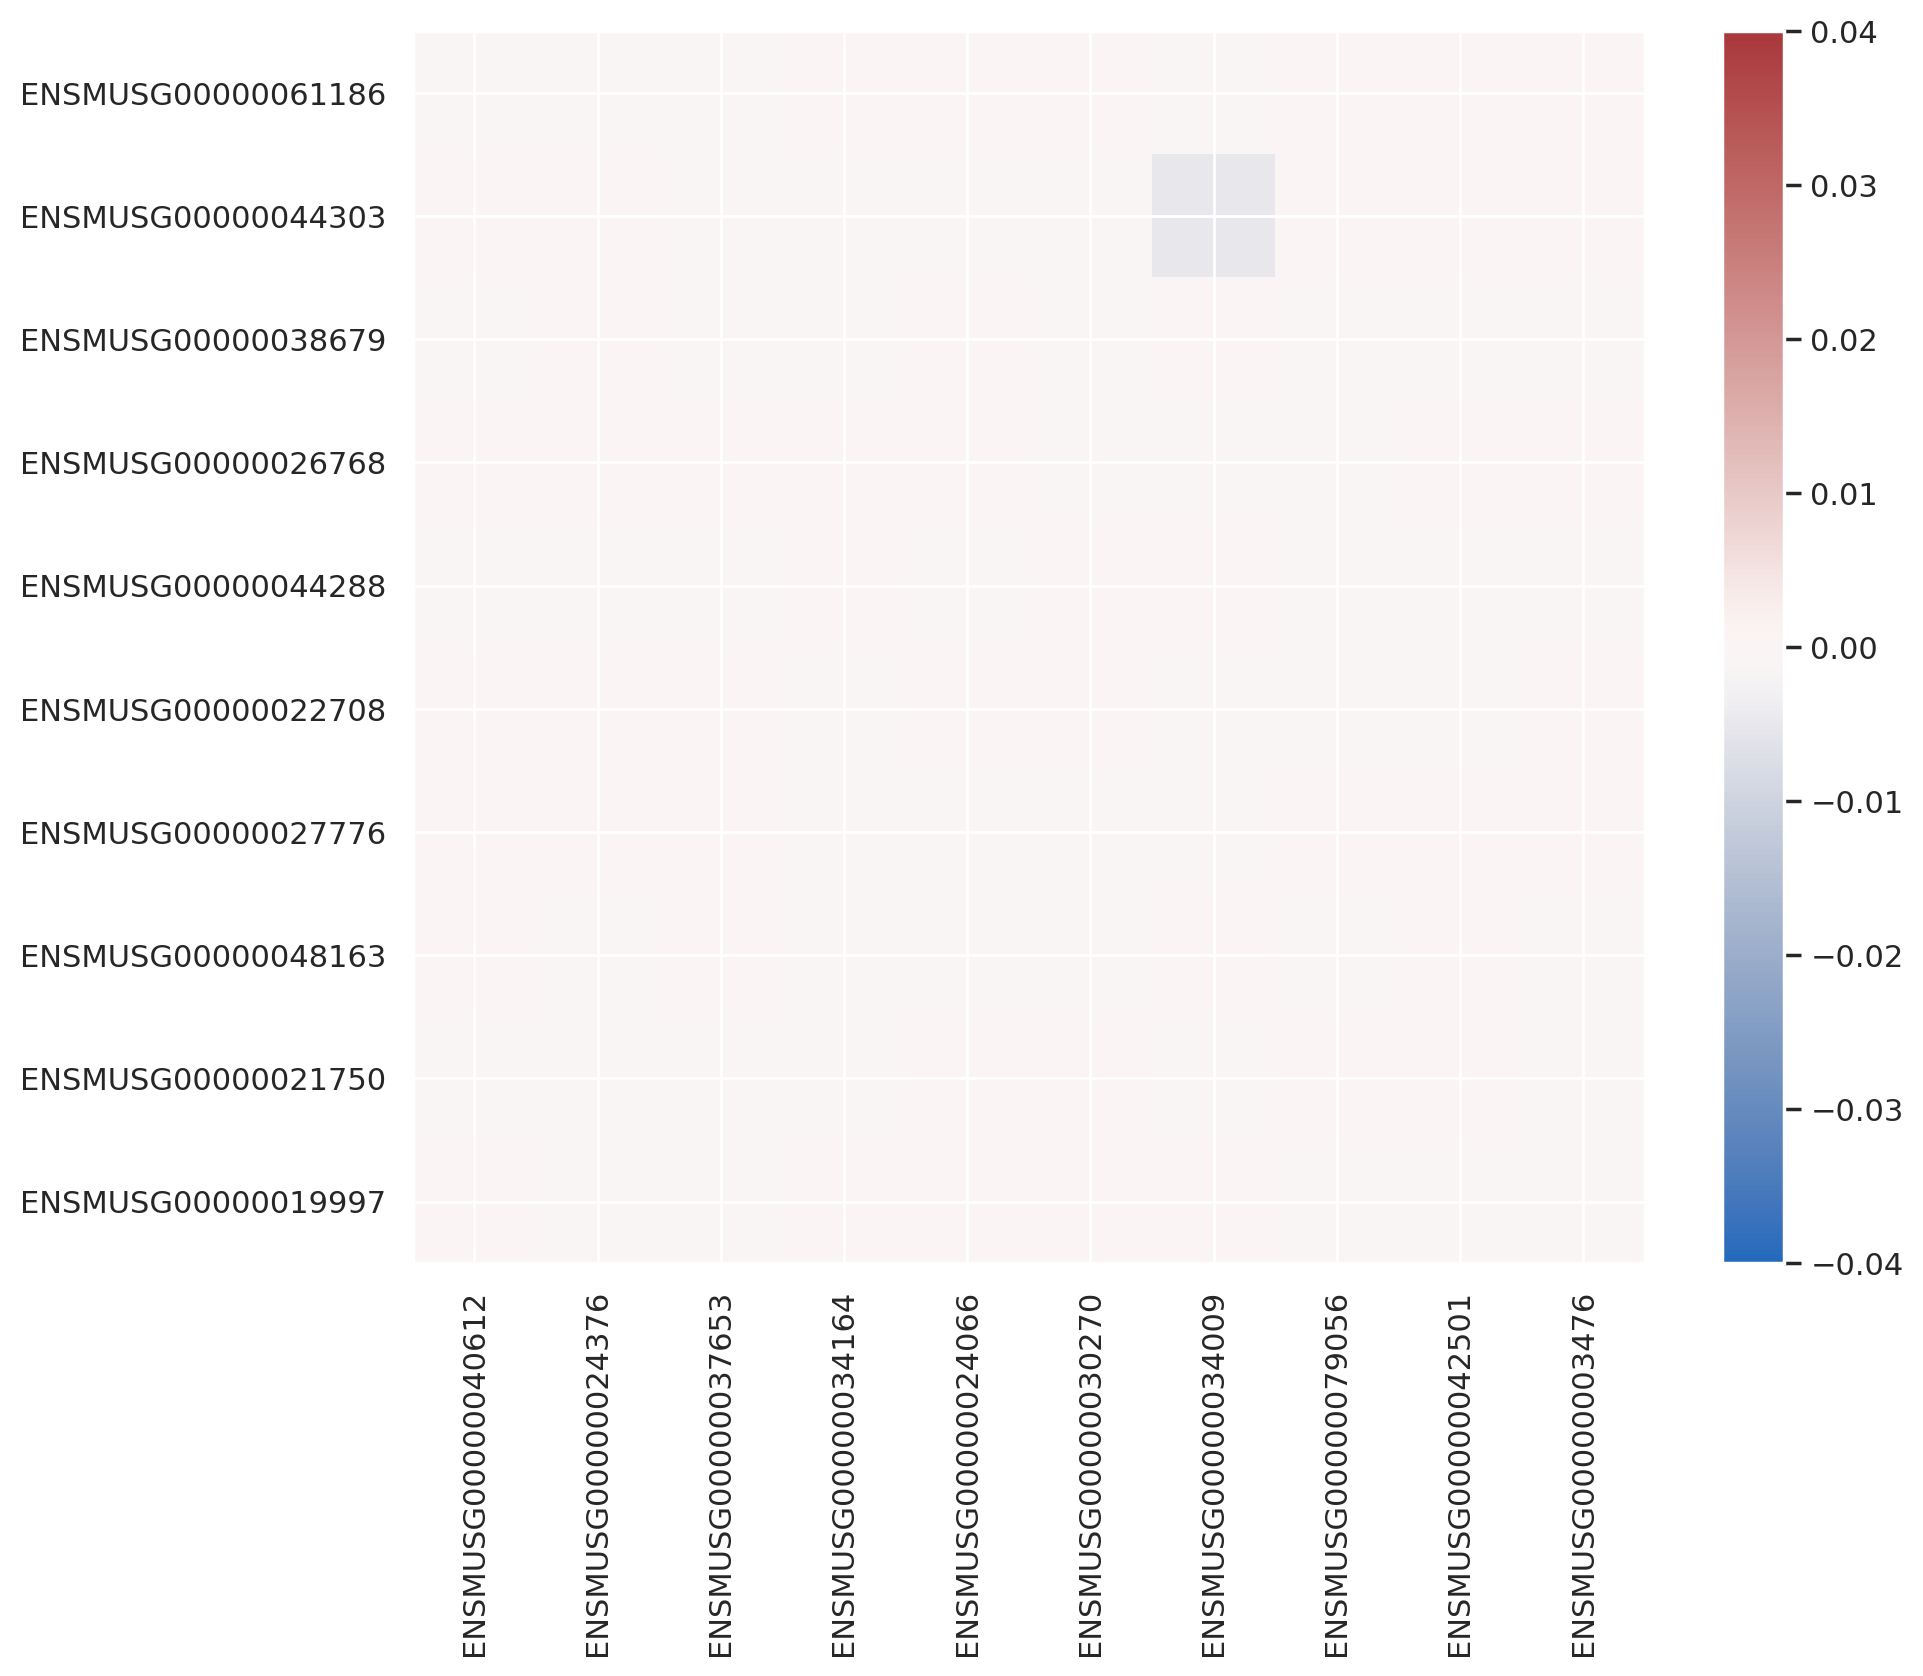

In [27]:
# take out a random patch

PATCH_SIZE = 10

idxCol = np.random.choice(meaningfulMatGR.shape[1], size=PATCH_SIZE, replace=False)
idxRow = np.random.choice(meaningfulMatGR.shape[0], size=PATCH_SIZE, replace=False)

patchMatGR = meaningfulMatGR[idxRow, :][:, idxCol]
patchGeneCol = genesCol[idxCol]
patchGeneRow = genesRow[idxRow]

plt.figure(figsize=(10, 8))
plt.imshow(patchMatGR, cmap='vlag', vmin=-.04, vmax=.04)
plt.colorbar()
plt.xticks(range(PATCH_SIZE), patchGeneCol, rotation=90)
plt.yticks(range(PATCH_SIZE), patchGeneRow)

In [28]:
# # take out a random column

# randColIdx = np.random.choice(meaningfulMatGR.shape[1], size=1, replace=False)
# randCol = meaningfulMatGR[:, randColIdx]
# randGene = genesCol[randColIdx]
# meaningfulY = np.abs(randCol) > THRESHOLD

# randCol = randCol[meaningfulY]

# randGene = randGene[meaningfulY]

# plt.figure(figsize=(10, 8))
# plt.imshow(randCol, cmap='vlag', vmin=-.04, vmax=.04)
# plt.colorbar()
# plt.xticks(range(1), randGene, rotation=90)
# plt.yticks(range(meaningfulMatGR.shape[0]), genesRow)

In [29]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"


/home/caoyufan/miniconda3/envs/kuanglu/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/caoyufan/miniconda3/envs/kuanglu/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


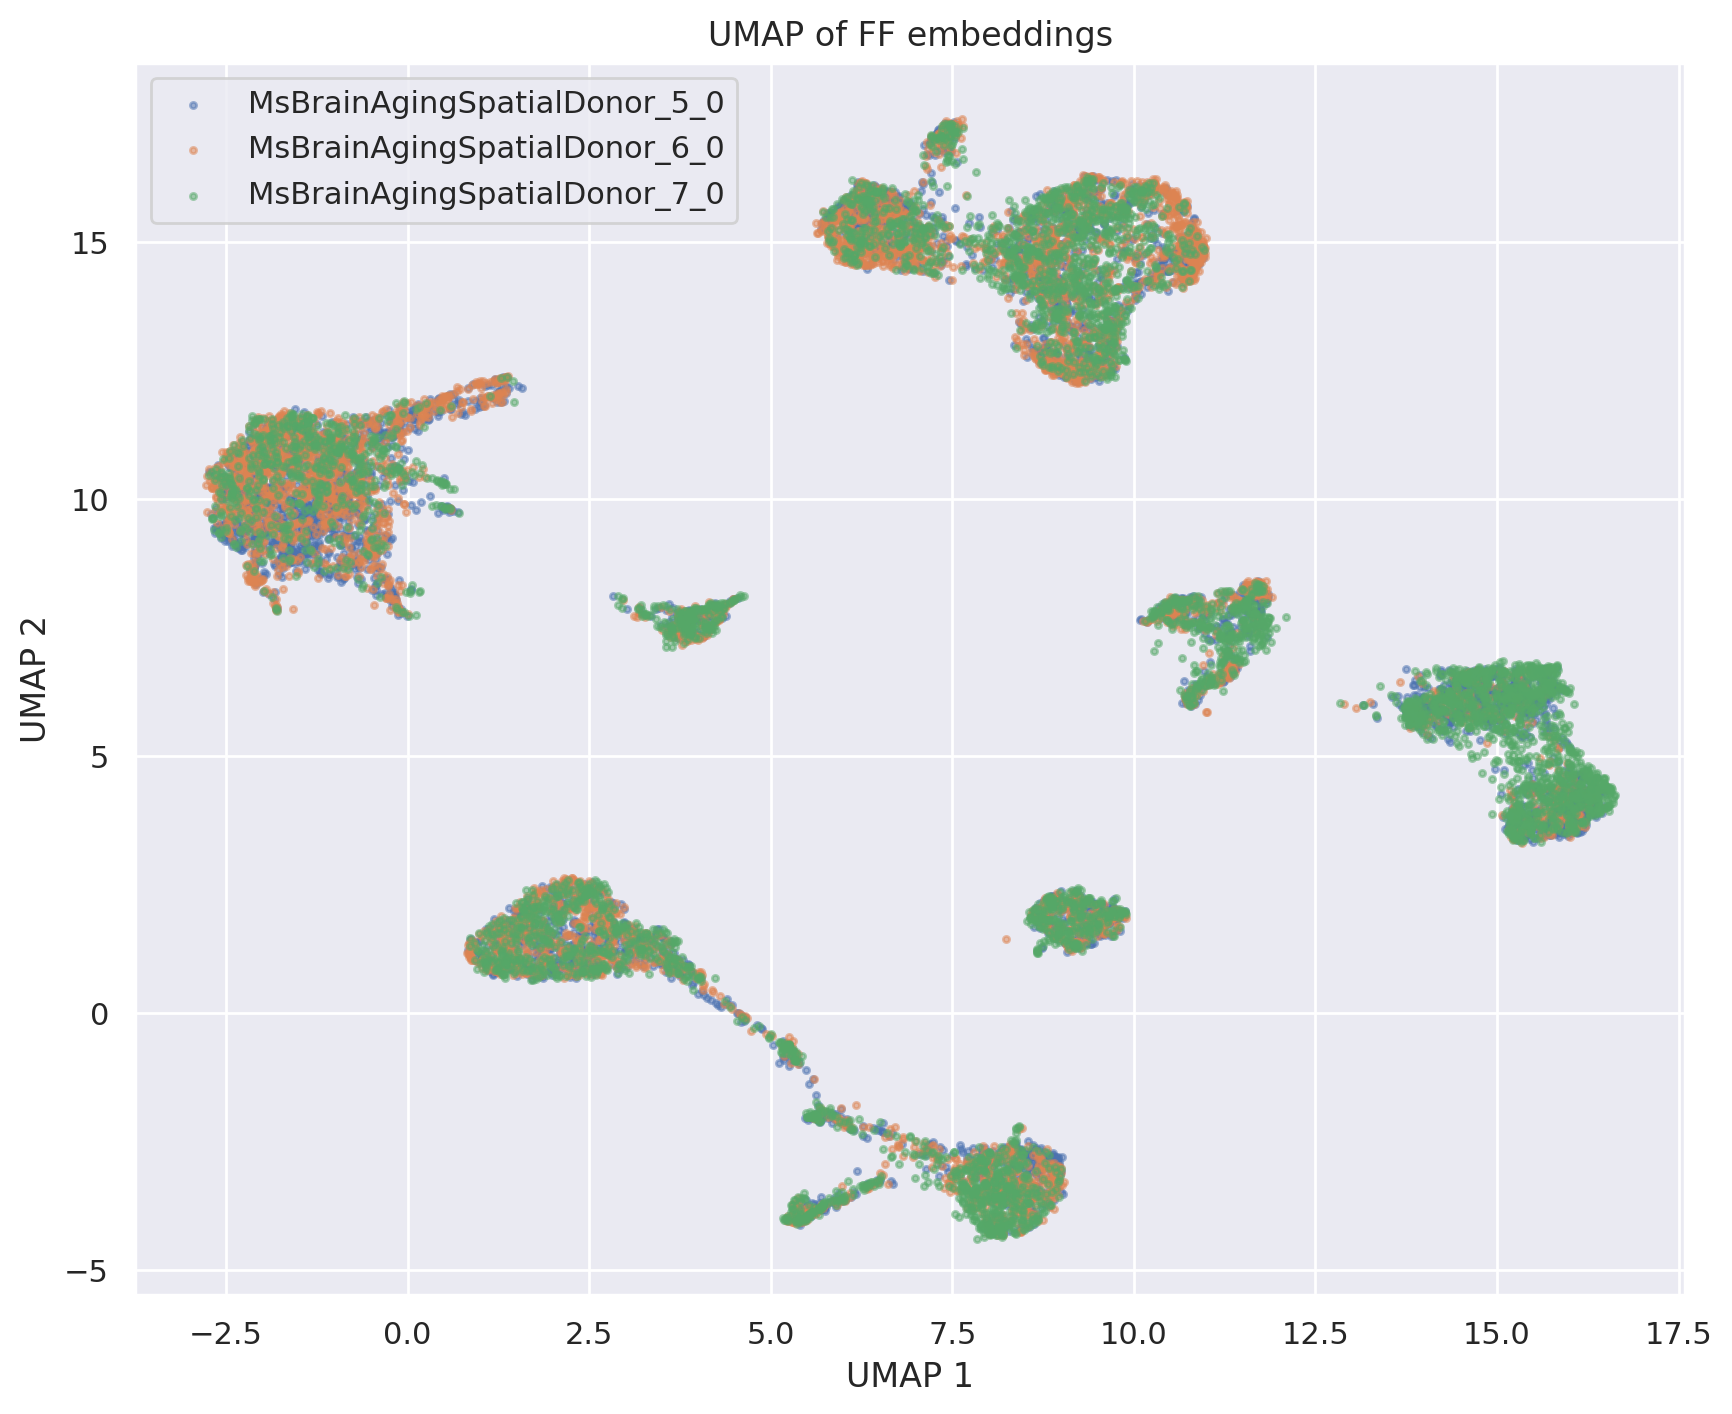

In [30]:
embeddingsFF = []
for Xs in train_Xs:
    embeddingsFF.append(model.getCellEmbedding(Xs))
    
embeddingsFFCat = np.concatenate(embeddingsFF, axis=0)
numCells = [Xs.shape[0] for Xs in train_Xs]

from umap import UMAP

embeddingUmapFF = UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42).fit_transform(embeddingsFFCat)

plt.figure(figsize=(10, 8))
cnt = 0
for i, numCell in enumerate(numCells):
    plt.scatter(embeddingUmapFF[cnt:cnt + numCell, 0], embeddingUmapFF[cnt:cnt + numCell, 1], label=chosen_slices[i], s=5, alpha=0.5)
    cnt += numCell
plt.legend()
plt.title('UMAP of FF embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

## Exp 2: Transformer for embedding

In [31]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "5"

train_Xs = []
chosen_slices = ['MsBrainAgingSpatialDonor_5_0', 'MsBrainAgingSpatialDonor_6_0', 
                 'MsBrainAgingSpatialDonor_7_0']
for i in chosen_slices:
    train_Xs.append(np.array(adata.X[adata.obs['donor_slice'] == i, :]))
    
validate_Xs = []
chosen_donors = ['MsBrainAgingSpatialDonor_8_0']
for i in chosen_donors:
    validate_Xs.append(np.array(adata.X[adata.obs['donor_slice'] == i, :]))
    
_, p = train_Xs[0].shape

class MyDataSet(Data.Dataset):
    def __init__(self, Xs):
        super(MyDataSet, self).__init__()
        self.Xs = [torch.Tensor(X) for X in Xs]
        
    def __len__(self):
        return len(self.Xs)

    def __getitem__(self, idx):
        return self.Xs[idx]

train_data = MyDataSet(train_Xs)
train_loader = Data.DataLoader(train_data, batch_size=1, shuffle=True) 

print("Training data dimensions:")
for i in train_Xs:
    print(i.shape)


Training data dimensions:
(5000, 374)
(5000, 374)
(5000, 374)


In [32]:
validate_data = MyDataSet(validate_Xs)
validate_loader = Data.DataLoader(validate_data, batch_size=1, shuffle=True)

print("Validation data dimensions:")
for i in validate_Xs:
    print(i.shape)


Validation data dimensions:
(5000, 374)


In [33]:
embed_config = {
    'embedType': 'transformer',
    'default': True,
    'd_input': p,
    'n_layers': 1,
}

model = kuanglu.Model(d_gene=p, 
                      d_denoise = [p], 
                      d_quality=[512, 256, 1], 
                      lbd=1.,
                      embed_config=embed_config,
                      ).to('cuda')


In [34]:
rec = model.fit('denoised', train_loader, validate_loader, [0, 500],
                fix=['embed', 'qualify', 'smooth', 'interact'], lr=1e-4)
rec = kuanglu.record_concat(rec, model.fit('smoothed', train_loader, validate_loader, [500, 750],
                                           fix=['denoise', 'interact'], lr=1e-4))
rec = kuanglu.record_concat(rec, model.fit('smoothed', train_loader, validate_loader, [750, 1000],
                                           fix=['interact'], lr=1e-4))
rec = kuanglu.record_concat(rec, model.fit('final', train_loader, validate_loader, [1000, 1250],
                                           fix=['denoise', 'embed', 'qualify', 'smooth'], lr=1e-4))
rec = kuanglu.record_concat(rec, model.fit('final', train_loader, validate_loader, [1250, 1500], lr=1e-4))


Epoch 0001 Train MSE 0.984 Validate MSE 1.017 Raw MSE 0.991
Epoch 0002 Train MSE 0.966 Validate MSE 1.038 Raw MSE 1.012


/home/caoyufan/kuanglu/examples/../kuanglu/model.py:312: UserWarning: Parameter containing:
tensor(100., device='cuda:0') is already fixed. They will be unfixed when exiting this function.
  warnings.warn(f"{param} is already fixed. They will be unfixed when exiting this function.")


Epoch 0003 Train MSE 0.968 Validate MSE 1.049 Raw MSE 1.025
Epoch 0004 Train MSE 0.965 Validate MSE 1.032 Raw MSE 1.006
Epoch 0005 Train MSE 0.947 Validate MSE 1.030 Raw MSE 1.009
Epoch 0006 Train MSE 0.974 Validate MSE 1.015 Raw MSE 0.993
Epoch 0007 Train MSE 0.964 Validate MSE 1.023 Raw MSE 1.001
Epoch 0008 Train MSE 0.954 Validate MSE 1.026 Raw MSE 1.004
Epoch 0009 Train MSE 0.965 Validate MSE 1.040 Raw MSE 1.020
Epoch 0010 Train MSE 0.980 Validate MSE 1.023 Raw MSE 0.999
Epoch 0011 Train MSE 0.945 Validate MSE 1.025 Raw MSE 1.008
Epoch 0012 Train MSE 0.948 Validate MSE 1.060 Raw MSE 1.039
Epoch 0013 Train MSE 0.953 Validate MSE 1.050 Raw MSE 1.028
Epoch 0014 Train MSE 0.960 Validate MSE 1.040 Raw MSE 1.018
Epoch 0015 Train MSE 0.949 Validate MSE 1.008 Raw MSE 0.983
Epoch 0016 Train MSE 0.969 Validate MSE 1.036 Raw MSE 1.013
Epoch 0017 Train MSE 0.958 Validate MSE 1.037 Raw MSE 1.015
Epoch 0018 Train MSE 0.940 Validate MSE 1.016 Raw MSE 0.993
Epoch 0019 Train MSE 0.951 Validate MSE 

Epoch 0042 Train MSE 0.933 Validate MSE 1.008 Raw MSE 0.997
Epoch 0043 Train MSE 0.932 Validate MSE 1.030 Raw MSE 1.018
Epoch 0044 Train MSE 0.937 Validate MSE 1.035 Raw MSE 1.025
Epoch 0045 Train MSE 0.935 Validate MSE 1.018 Raw MSE 1.009
Epoch 0046 Train MSE 0.926 Validate MSE 1.015 Raw MSE 1.010
Epoch 0047 Train MSE 0.926 Validate MSE 1.022 Raw MSE 1.014
Epoch 0048 Train MSE 0.924 Validate MSE 1.017 Raw MSE 1.011
Epoch 0049 Train MSE 0.924 Validate MSE 1.011 Raw MSE 1.003
Epoch 0050 Train MSE 0.945 Validate MSE 1.017 Raw MSE 1.010
Epoch 0051 Train MSE 0.918 Validate MSE 1.022 Raw MSE 1.017
Epoch 0052 Train MSE 0.921 Validate MSE 1.022 Raw MSE 1.014
Epoch 0053 Train MSE 0.931 Validate MSE 0.991 Raw MSE 0.984
Epoch 0054 Train MSE 0.919 Validate MSE 0.988 Raw MSE 0.978
Epoch 0055 Train MSE 0.932 Validate MSE 1.039 Raw MSE 1.034
Epoch 0056 Train MSE 0.926 Validate MSE 1.029 Raw MSE 1.025
Epoch 0057 Train MSE 0.904 Validate MSE 1.031 Raw MSE 1.031
Epoch 0058 Train MSE 0.923 Validate MSE 

Text(0, 0.5, 'MSE')

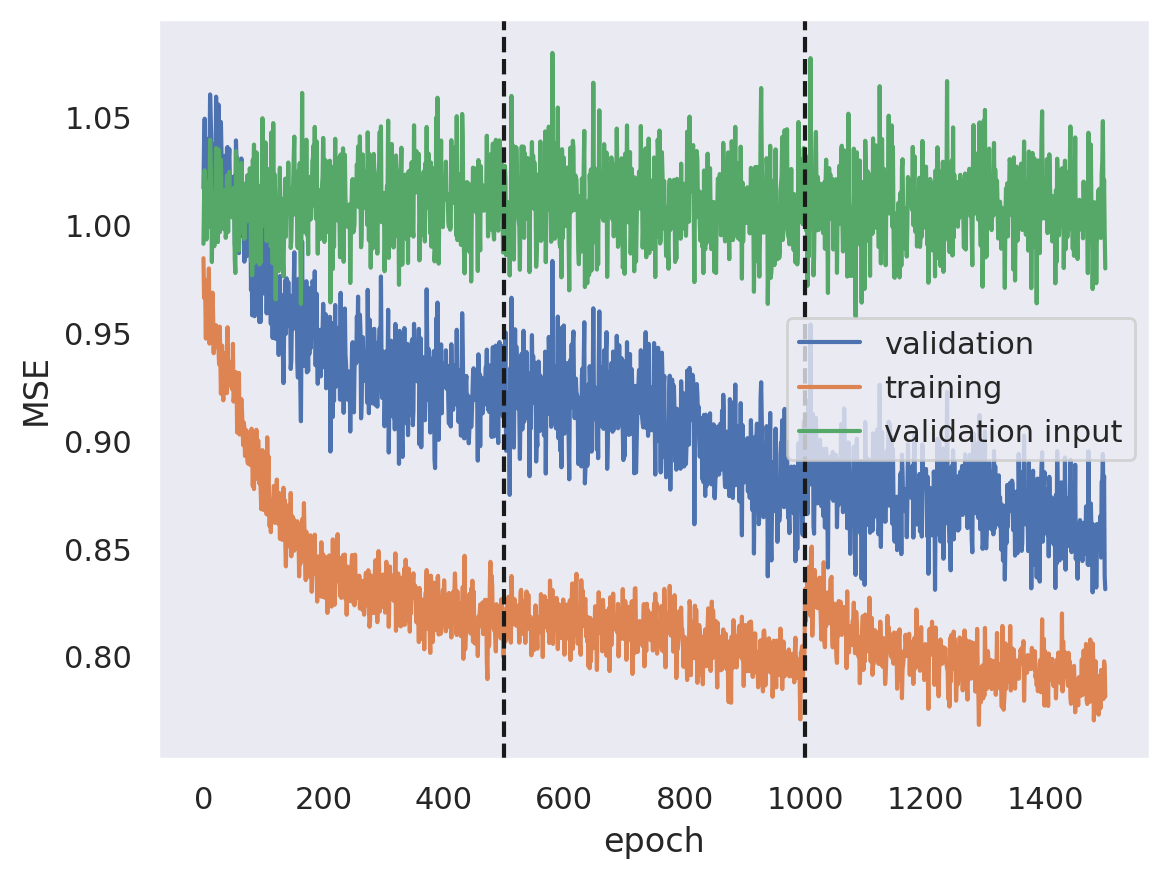

In [35]:
plt.plot(rec['validate_epoch'], rec['validate_mse'], label='validation')
plt.plot(rec['train_epoch'], rec['train_mse'], label='training')
plt.plot(rec['validate_epoch'], rec['raw_mse'], label='validation input')
plt.legend()
plt.grid()
plt.axvline(500, ls='--', c='k')
plt.axvline(1000, ls='--', c='k')
plt.xlabel('epoch')
plt.ylabel('MSE')


In [36]:
mse_df = pd.DataFrame({'epoch': rec['validate_epoch'], 'mse': rec['validate_mse']})

def epoch2stage(x):
    if x < 250: return 'pre-denoise'
    elif x < 500: return 'denoise'
    elif x < 750: return 'pre-denoise-smooth'
    elif x < 1000: return 'denoise-smooth'
    elif x < 1250: return 'pre-denoise-smooth-enhance'
    elif x < 1500: return 'denoise-smooth-enhance'
    else: raise NotImplementedError('x >= 1500 not allowed')

mse_df['stage'] = mse_df['epoch'].apply(epoch2stage)
mse_df


epoch       mse                   stage
0         0  1.016909             pre-denoise
1         1  1.038028             pre-denoise
2         2  1.049143             pre-denoise
3         3  1.031713             pre-denoise
4         4  1.029989             pre-denoise
...     ...       ...                     ...
1495   1495  0.893756  denoise-smooth-enhance
1496   1496  0.870857  denoise-smooth-enhance
1497   1497  0.883467  denoise-smooth-enhance
1498   1498  0.837159  denoise-smooth-enhance
1499   1499  0.831082  denoise-smooth-enhance

[1500 rows x 3 columns]

/home/caoyufan/miniconda3/envs/kuanglu/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/caoyufan/miniconda3/envs/kuanglu/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/caoyufan/miniconda3/envs/kuanglu/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


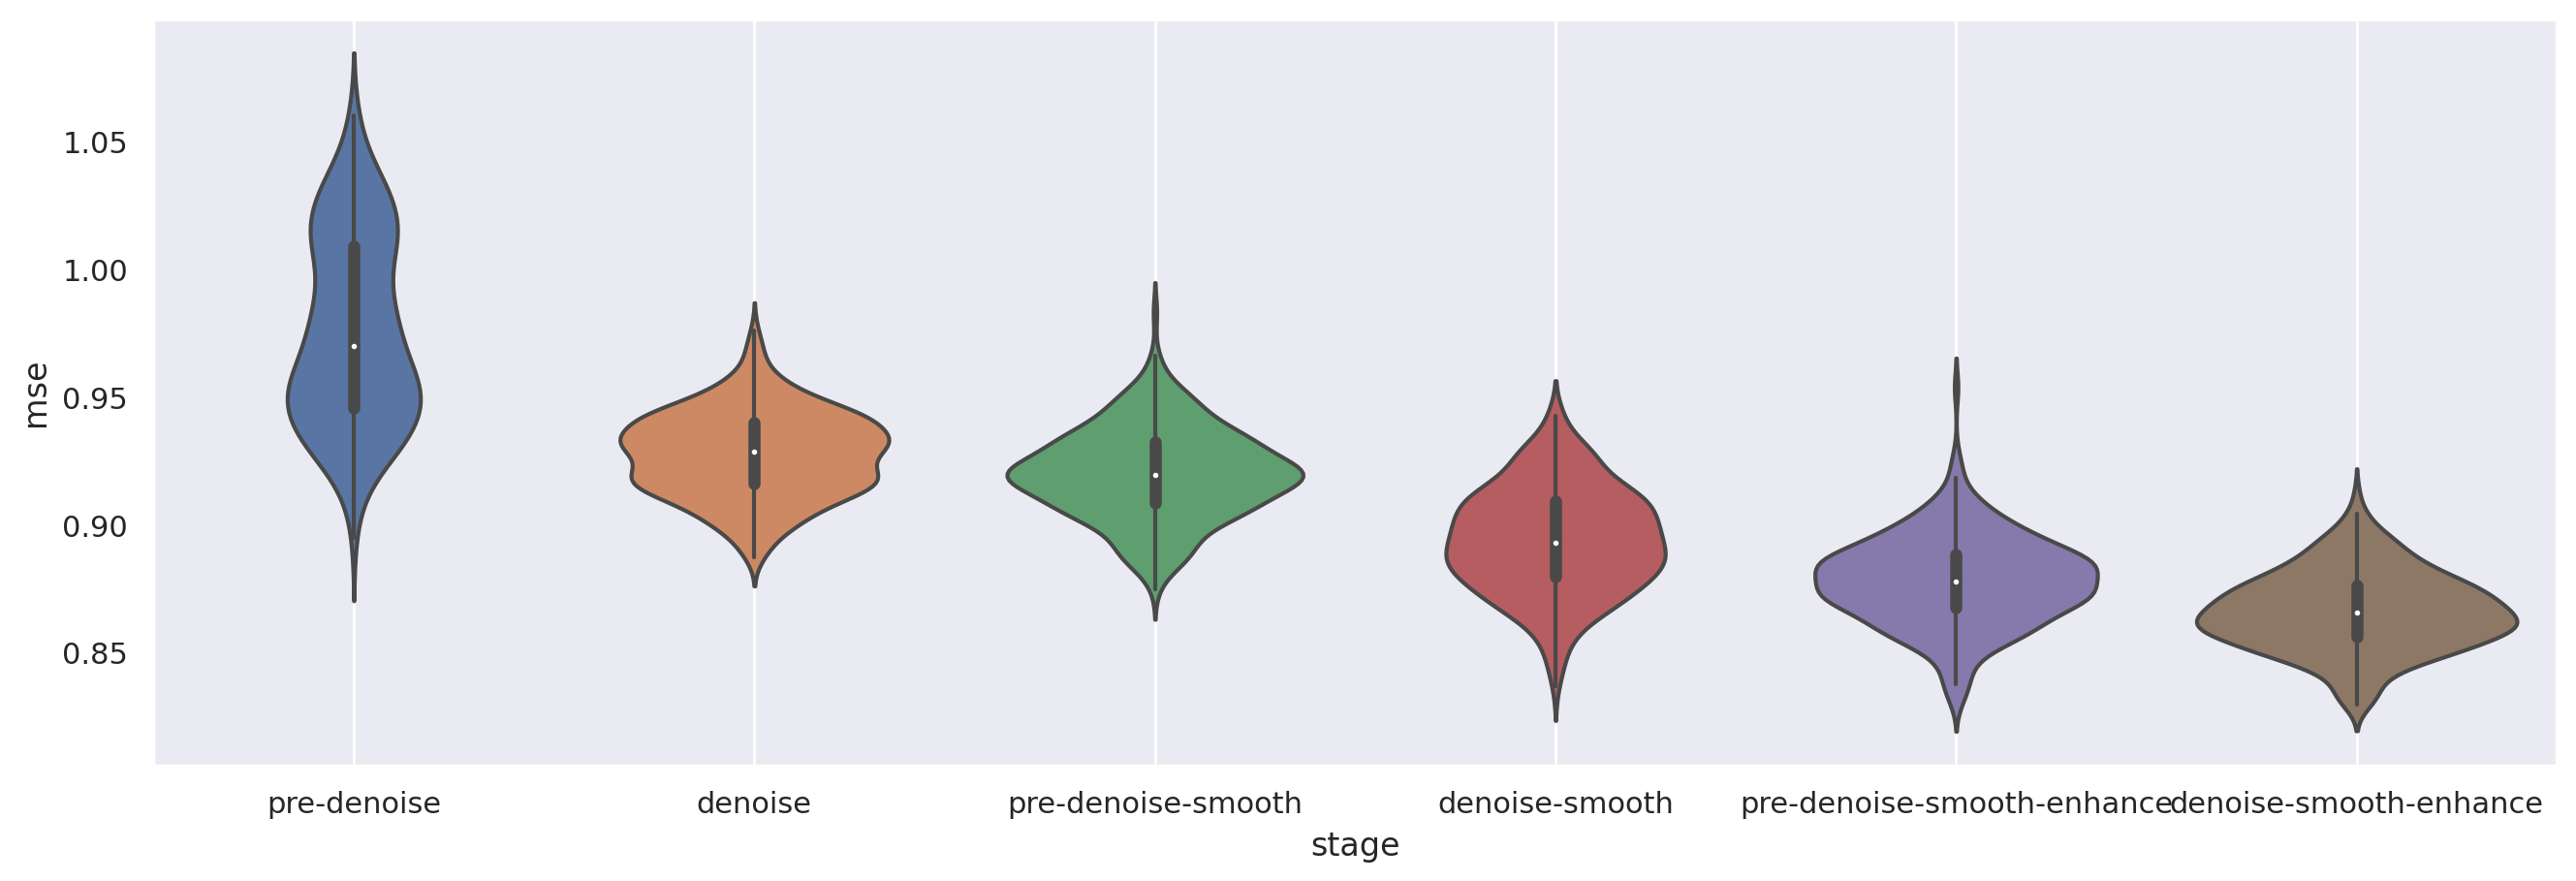

In [37]:
# sns.violinplot(mse_df[~mse_df['stage'].str.contains('pre-')], x='stage', y='mse')
%config InlineBackend.figure_format ='retina'
plt.figure(figsize=(16, 5))
sns.violinplot(mse_df, x='stage', y='mse')
plt.grid()


In [38]:
u_stat, p_val = sp.stats.mannwhitneyu(mse_df.loc[mse_df['stage'] == 'denoise', 'mse'], 
                      mse_df.loc[mse_df['stage'] == 'denoise-smooth', 'mse'])

print('p =', p_val, 
      'f =', u_stat / sum(mse_df['stage'] == 'denoise') / sum(mse_df['stage'] == 'denoise-smooth'))


p = 3.904408074834399e-53 f = 0.896576


In [39]:
u_stat, p_val = sp.stats.mannwhitneyu(mse_df.loc[mse_df['stage'] == 'denoise-smooth', 'mse'], 
                      mse_df.loc[mse_df['stage'] == 'denoise-smooth-enhance', 'mse'])
print('p =', p_val, 
      'f =', u_stat / sum(mse_df['stage'] == 'denoise-smooth') / sum(mse_df['stage'] == 'denoise-smooth-enhance'))


p = 3.5745563574444894e-44 f = 0.8603200000000001


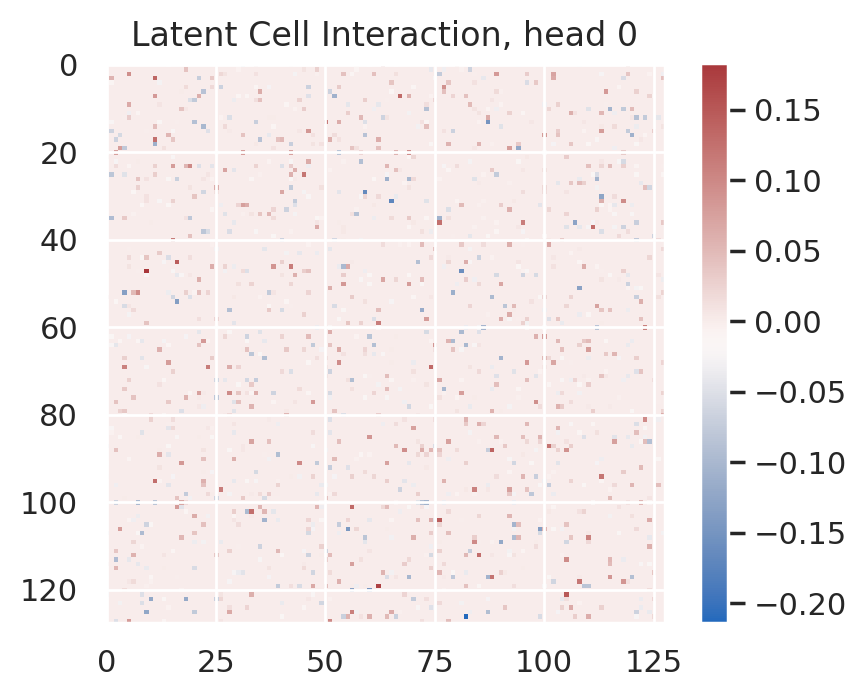

In [40]:
# Plot heatmap of the parameters in cell interaction module

weight_CIs = []
for head in range(len(model.cell_interacts)):
    weight_CIs.append(model.cell_interacts[head].transform.data)

plt.figure(figsize=(10, 8))
for i, weight_CI in enumerate(weight_CIs):
    weight_array = weight_CI.cpu().numpy()
    plt.subplot(2, 2, i + 1)
    plt.imshow(weight_array, cmap='vlag')
    plt.colorbar()
    plt.title(f'Latent Cell Interaction, head {i}')
plt.show()


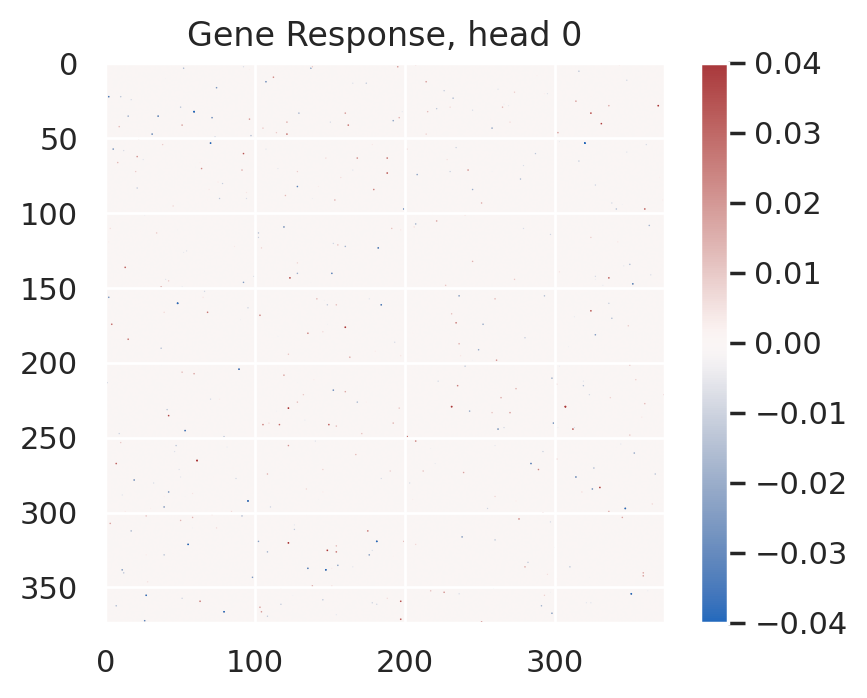

In [41]:
# Plot heatmap of the parameters in gene response module

weight_GRs = []
for head in range(len(model.cell_interacts)):
    weight_GRs.append(model.cell_interacts[head].gene_response.data)

plt.figure(figsize=(10, 8))
for i, weight_GR in enumerate(weight_GRs):
    weight_array = weight_GR.cpu().numpy()
    plt.subplot(2, 2, i + 1)
    plt.imshow(weight_array, cmap='vlag', vmin=-.04, vmax=.04)
    plt.colorbar()
    plt.title(f'Gene Response, head {i}')
plt.show()


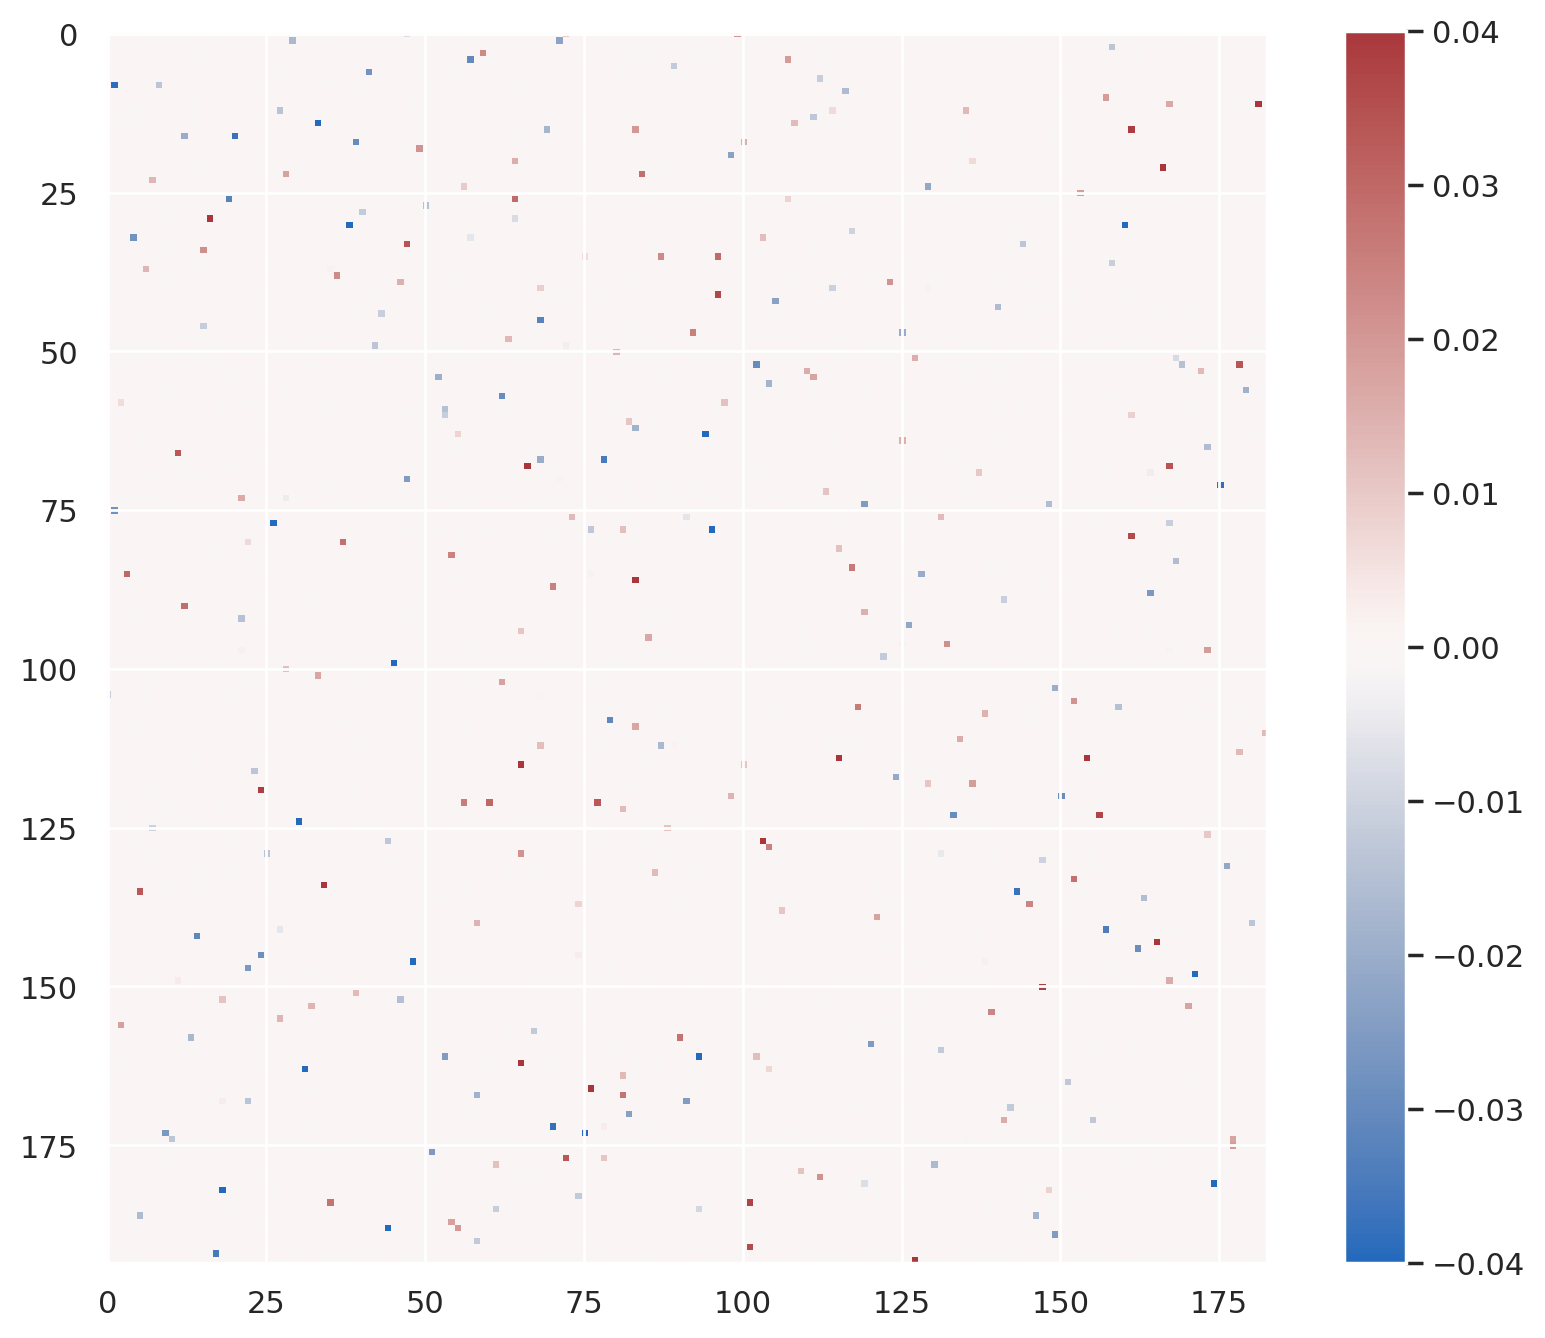

In [42]:
# Extract meaningful weights from Gene Response
THRESHOLD = 0.01

matGR = model.cell_interacts[0].gene_response.data.cpu().numpy()
col_max = np.max(np.abs(matGR), axis=0)
row_max = np.max(np.abs(matGR), axis=1)

meaningfulCols = np.where(col_max > THRESHOLD)[0]
meaningfulRows = np.where(row_max > THRESHOLD)[0]

meaningfulMatGR = matGR[meaningfulRows, :][:, meaningfulCols]

# meaningfulMatGR = np.clip(meaningfulMatGR, -.04, .04)

plt.figure(figsize=(10, 8))
plt.imshow(meaningfulMatGR, cmap='vlag', vmin=-.04, vmax=.04)
plt.colorbar()


In [43]:
# Find the indices of highest absolute values in the meaningfulMatGR

topK = 10
topK_indices = np.argsort(np.abs(matGR), axis=None)[-topK:]

topK_indices = np.unravel_index(topK_indices, matGR.shape)

topK_indices


(array([249, 354, 297, 229, 319,  53, 160, 265,  32, 229]),
 array([201, 351, 347, 231, 181, 320,  48,  61,  59, 307]))

In [44]:
np.abs(matGR)[topK_indices]


array([0.06052958, 0.06228109, 0.06299961, 0.06620296, 0.06674422,
       0.07172538, 0.07708675, 0.07728413, 0.08360508, 0.09126596],
      dtype=float32)

In [45]:
# check the corresponding genes

LR_pairs = []

for i in range(topK):
    LR_pairs.append((adata.var.index[topK_indices[1][i]], 
                     adata.var.index[topK_indices[0][i]]))

LR_pairs


[('ENSMUSG00000023992', 'ENSMUSG00000057738'),
 ('ENSMUSG00000024610', 'ENSMUSG00000034271'),
 ('ENSMUSG00000063568', 'ENSMUSG00000029084'),
 ('ENSMUSG00000063873', 'ENSMUSG00000023067'),
 ('ENSMUSG00000023886', 'ENSMUSG00000021779'),
 ('ENSMUSG00000024598', 'ENSMUSG00000026011'),
 ('ENSMUSG00000021680', 'ENSMUSG00000026820'),
 ('ENSMUSG00000022419', 'ENSMUSG00000037138'),
 ('ENSMUSG00000029417', 'ENSMUSG00000044303'),
 ('ENSMUSG00000025486', 'ENSMUSG00000023067')]

In [46]:
import pandas as pd

lr_pairs = pd.read_csv('./mouse_lr_pair.csv')

lgID = lr_pairs['ligand_ensembl_gene_id']
rpID = lr_pairs['receptor_ensembl_gene_id']

lrID = pd.concat([lgID, rpID], axis=1)
# lrID

geneIDBank = set(adata.var.index)

# filter out the genes that are not in the dataset

lrID = lrID[lrID['ligand_ensembl_gene_id'].isin(geneIDBank) &
            lrID['receptor_ensembl_gene_id'].isin(geneIDBank)]
lrID


ligand_ensembl_gene_id receptor_ensembl_gene_id
26       ENSMUSG00000035385       ENSMUSG00000049103
50       ENSMUSG00000000869       ENSMUSG00000026770
52       ENSMUSG00000000869       ENSMUSG00000031304
275      ENSMUSG00000017344       ENSMUSG00000026768
323      ENSMUSG00000019772       ENSMUSG00000022206
334      ENSMUSG00000019997       ENSMUSG00000020122
339      ENSMUSG00000019997       ENSMUSG00000030786
467      ENSMUSG00000024164       ENSMUSG00000026616
469      ENSMUSG00000024164       ENSMUSG00000030724
470      ENSMUSG00000024164       ENSMUSG00000030786
1144     ENSMUSG00000024164       ENSMUSG00000000290
1153     ENSMUSG00000051439       ENSMUSG00000000290
1212     ENSMUSG00000049796       ENSMUSG00000003476
1296     ENSMUSG00000019772       ENSMUSG00000011171
1356     ENSMUSG00000025746       ENSMUSG00000020122
1357     ENSMUSG00000028364       ENSMUSG00000020122
1473     ENSMUSG00000002985       ENSMUSG00000023992
1557     ENSMUSG00000028364       ENSMUSG00000026768
1653     ENSMUSG00000002985       ENSMUSG00000015243
1900     ENSMUSG00000066551       ENSMUSG00000030786

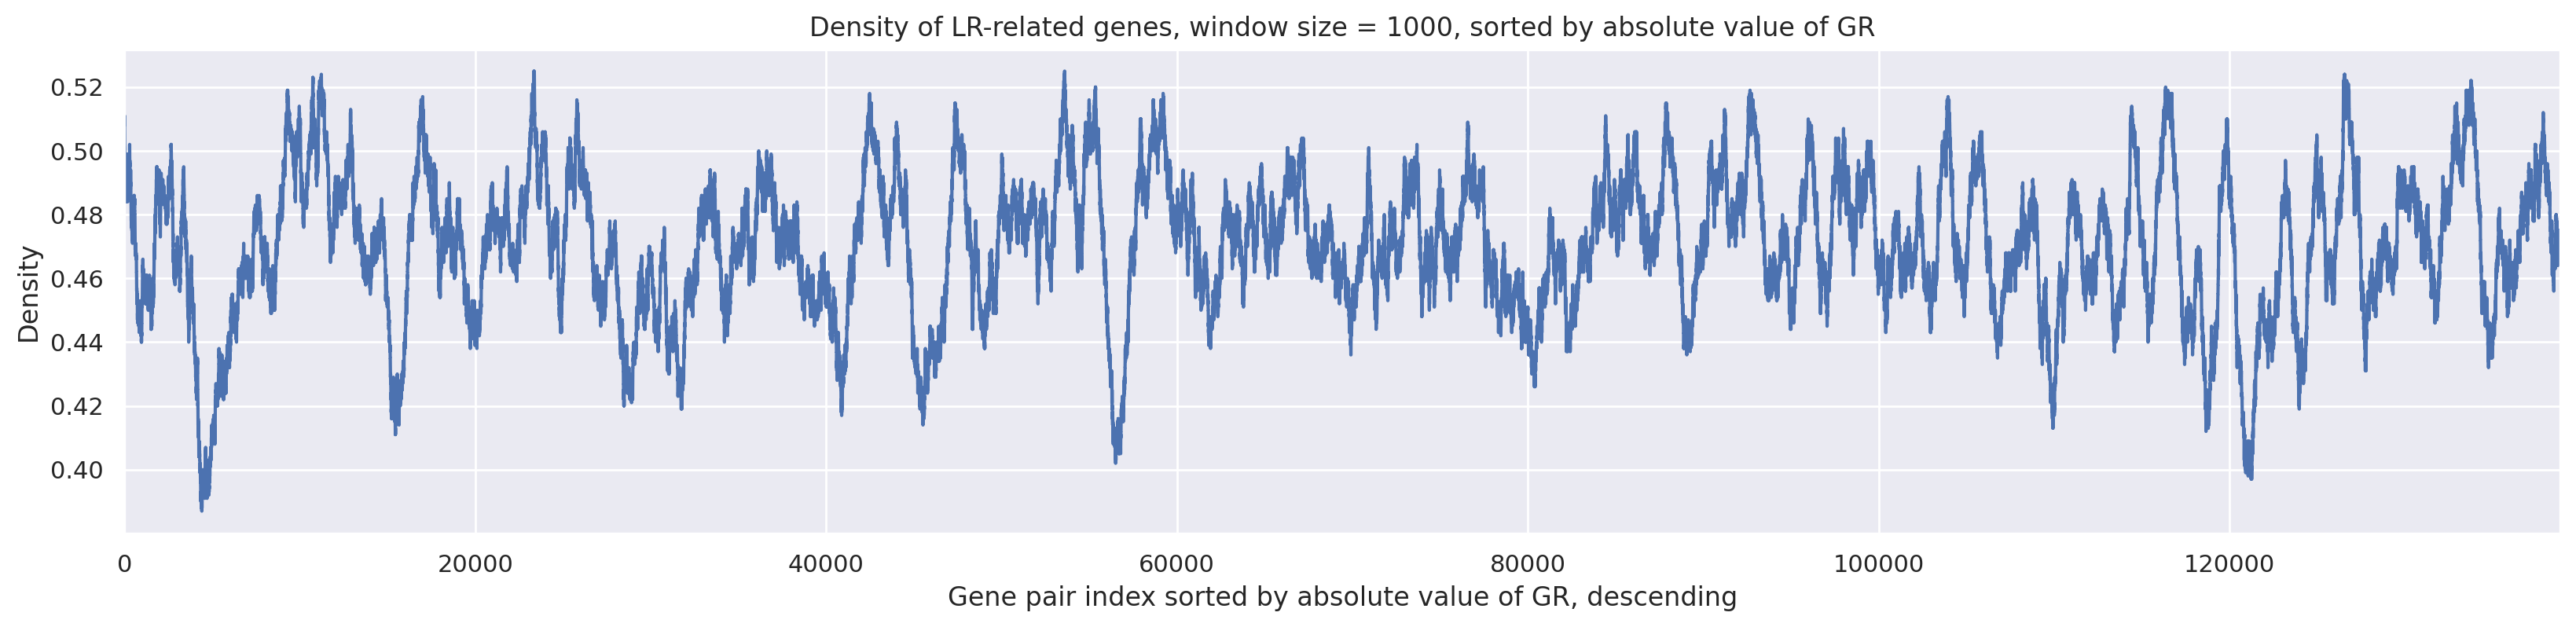

In [47]:
ranked_indices = np.argsort(np.abs(matGR), axis=None)
ranked_indices = np.unravel_index(ranked_indices, matGR.shape)

LR_related_genes = set(lgID) | set(rpID)

hasRelatedGenes = []

for indices in zip(ranked_indices[0], ranked_indices[1]):
    cnt = 0
    if adata.var.index[indices[0]] in LR_related_genes:
        cnt += 1
    if adata.var.index[indices[1]] in LR_related_genes:
        cnt += 1
    hasRelatedGenes.append(cnt)

hasRelatedGenes = np.array(hasRelatedGenes)

WINDOW_SIZE = 1000

density = []

for i in range(len(hasRelatedGenes) - WINDOW_SIZE):
    density.append(np.mean(hasRelatedGenes[i:i + WINDOW_SIZE]))
    
%config InlineBackend.figure_format ='retina'
sns.set()
plt.figure(figsize=(20, 4));
plt.plot(density);
plt.title(f'Density of LR-related genes, window size = {WINDOW_SIZE}, sorted by absolute value of GR');
plt.xlim(0, len(hasRelatedGenes) - WINDOW_SIZE);
plt.xlabel('Gene pair index sorted by absolute value of GR, descending');
plt.ylabel('Density');


In [48]:
genesCol = adata.var_names[meaningfulCols]
genesRow = adata.var_names[meaningfulRows]

genesCol, genesRow


(Index(['ENSMUSG00000035783', 'ENSMUSG00000020178', 'ENSMUSG00000024397',
        'ENSMUSG00000017390', 'ENSMUSG00000036777', 'ENSMUSG00000037010',
        'ENSMUSG00000024411', 'ENSMUSG00000060802', 'ENSMUSG00000048251',
        'ENSMUSG00000031375',
        ...
        'ENSMUSG00000046160', 'ENSMUSG00000024610', 'ENSMUSG00000019880',
        'ENSMUSG00000031997', 'ENSMUSG00000053007', 'ENSMUSG00000028370',
        'ENSMUSG00000045875', 'ENSMUSG00000038872', 'ENSMUSG00000044647',
        'ENSMUSG00000025754'],
       dtype='object', length=183),
 Index(['ENSMUSG00000020178', 'ENSMUSG00000024397', 'ENSMUSG00000036777',
        'ENSMUSG00000060802', 'ENSMUSG00000021835', 'ENSMUSG00000028487',
        'ENSMUSG00000045532', 'ENSMUSG00000073418', 'ENSMUSG00000035385',
        'ENSMUSG00000019997',
        ...
        'ENSMUSG00000053007', 'ENSMUSG00000031839', 'ENSMUSG00000025357',
        'ENSMUSG00000045875', 'ENSMUSG00000020160', 'ENSMUSG00000038872',
        'ENSMUSG00000044647', 'ENSM

In [49]:
meaningfulMatGR.shape


(194, 183)

([<matplotlib.axis.YTick at 0x7f696101d010>,
 [Text(0, 0, 'ENSMUSG00000061911'),
  Text(0, 1, 'ENSMUSG00000027398'),
  Text(0, 2, 'ENSMUSG00000017707'),
  Text(0, 3, 'ENSMUSG00000024598'),
  Text(0, 4, 'ENSMUSG00000073418'),
  Text(0, 5, 'ENSMUSG00000000318'),
  Text(0, 6, 'ENSMUSG00000016529'),
  Text(0, 7, 'ENSMUSG00000079465'),
  Text(0, 8, 'ENSMUSG00000007891'),
  Text(0, 9, 'ENSMUSG00000046182')])

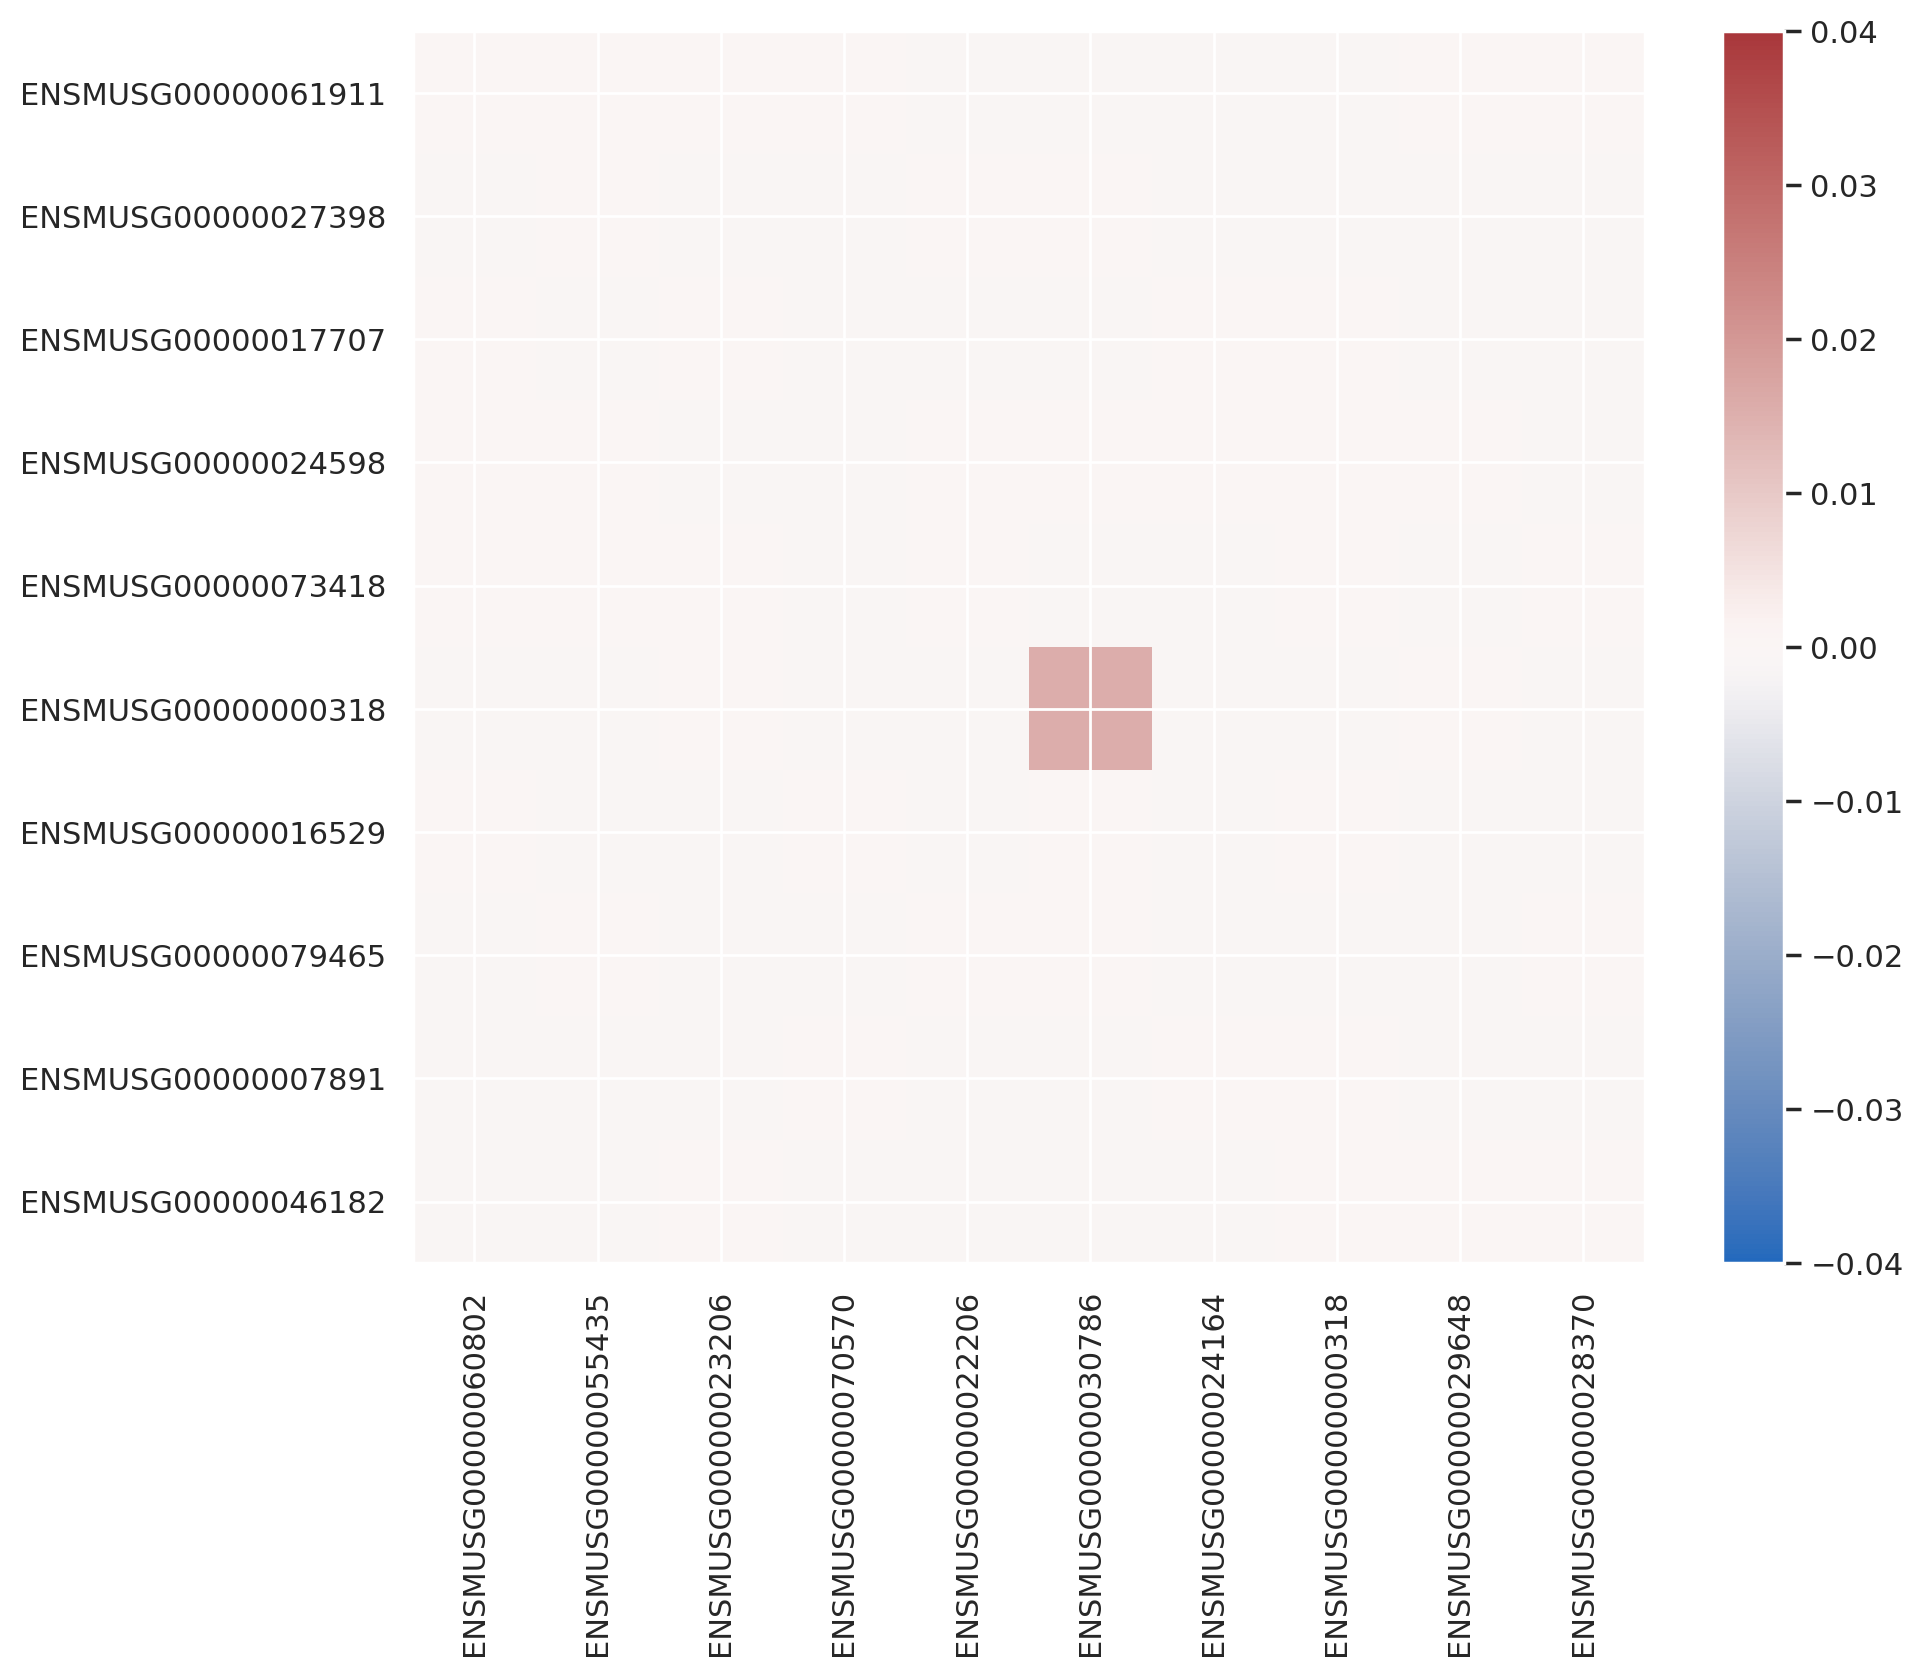

In [50]:
# take out a random patch

PATCH_SIZE = 10

idxCol = np.random.choice(meaningfulMatGR.shape[1], size=PATCH_SIZE, replace=False)
idxRow = np.random.choice(meaningfulMatGR.shape[0], size=PATCH_SIZE, replace=False)

patchMatGR = meaningfulMatGR[idxRow, :][:, idxCol]
patchGeneCol = genesCol[idxCol]
patchGeneRow = genesRow[idxRow]

plt.figure(figsize=(10, 8))
plt.imshow(patchMatGR, cmap='vlag', vmin=-.04, vmax=.04)
plt.colorbar()
plt.xticks(range(PATCH_SIZE), patchGeneCol, rotation=90)
plt.yticks(range(PATCH_SIZE), patchGeneRow)


In [51]:
# # take out a random column

# randColIdx = np.random.choice(meaningfulMatGR.shape[1], size=1, replace=False)
# randCol = meaningfulMatGR[:, randColIdx]
# randGene = genesCol[randColIdx]
# meaningfulY = np.abs(randCol) > THRESHOLD

# randCol = randCol[meaningfulY]

# randGene = randGene[meaningfulY]

# plt.figure(figsize=(10, 8))
# plt.imshow(randCol, cmap='vlag', vmin=-.04, vmax=.04)
# plt.colorbar()
# plt.xticks(range(1), randGene, rotation=90)
# plt.yticks(range(meaningfulMatGR.shape[0]), genesRow)
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"



/home/caoyufan/miniconda3/envs/kuanglu/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


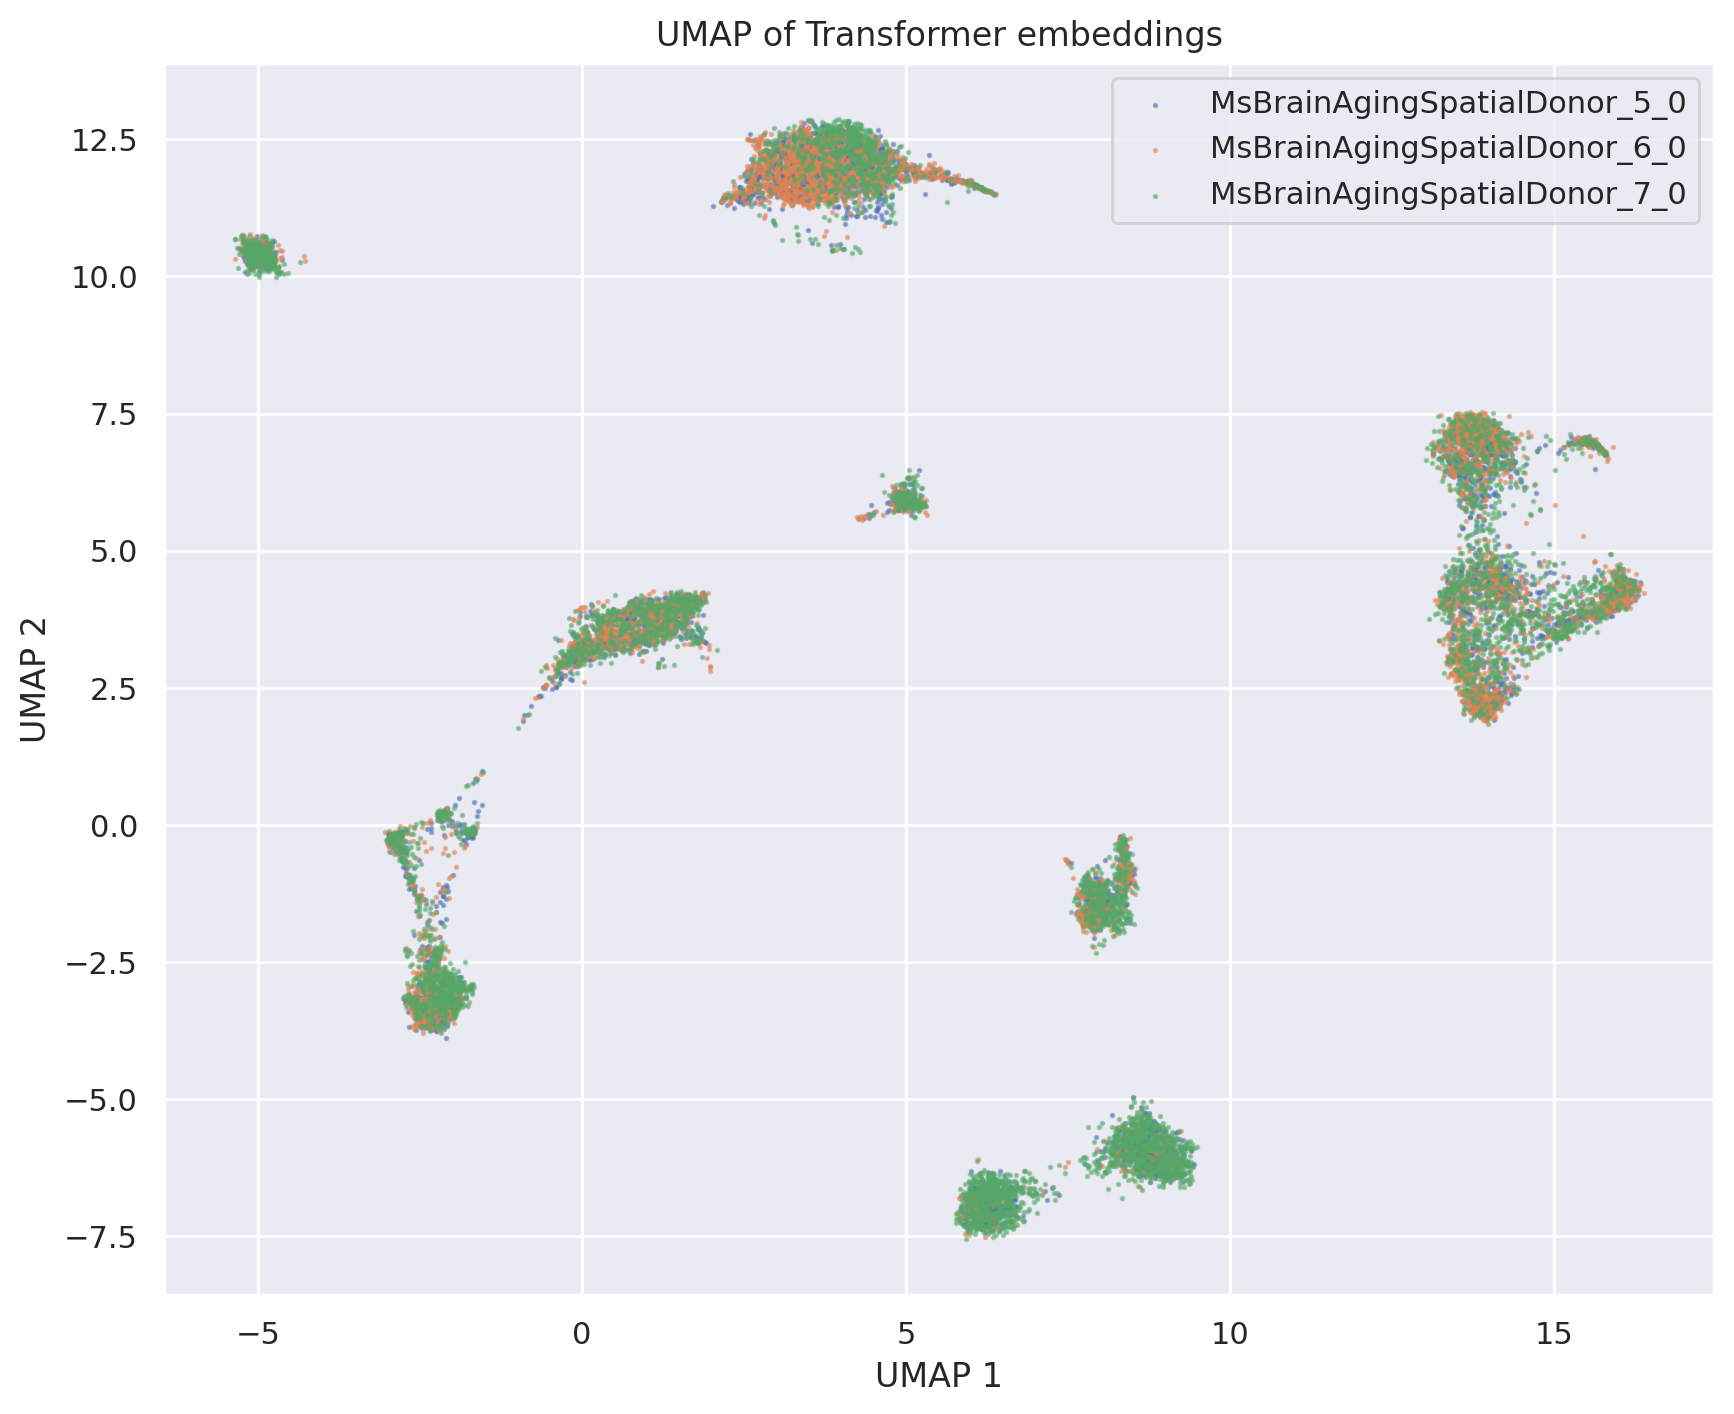

In [52]:
embeddingsTrf = []
for Xs in train_Xs:
    embeddingsTrf.append(model.getCellEmbedding(Xs[None, :, :])[0])
    
embeddingsTrfCat = np.concatenate(embeddingsTrf, axis=0)
numCells = [Xs.shape[0] for Xs in train_Xs]

from umap import UMAP

embeddingUmapTrf = UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42).fit_transform(embeddingsTrfCat)

plt.figure(figsize=(10, 8))
cnt = 0
for i, numCell in enumerate(numCells):
    plt.scatter(embeddingUmapTrf[cnt:cnt + numCell, 0], embeddingUmapTrf[cnt:cnt + numCell, 1], label=chosen_slices[i], s=1, alpha=0.5)
    cnt += numCell
plt.legend()
plt.title('UMAP of Transformer embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

In [53]:
adataTrain = adata[adata.obs['donor_slice'].isin(chosen_slices), :]
adataTrain.obs['donor_slice']

/home/caoyufan/miniconda3/envs/kuanglu/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


59698927139295812388362741003745788589     MsBrainAgingSpatialDonor_5_0
135286066239277822083099936449845537191    MsBrainAgingSpatialDonor_5_0
36230115600570954051386082817058679406     MsBrainAgingSpatialDonor_5_0
272700543442277102036408593339718252224    MsBrainAgingSpatialDonor_5_0
217538183781914655709760009157548792709    MsBrainAgingSpatialDonor_5_0
                                                       ...             
125382427981999537759967071592698829967    MsBrainAgingSpatialDonor_7_0
155832986581483488064324437540534635925    MsBrainAgingSpatialDonor_7_0
334492001200555147743356206055789995001    MsBrainAgingSpatialDonor_7_0
10675129708281426744450783644033766312     MsBrainAgingSpatialDonor_7_0
336331504784704328393588895247069464714    MsBrainAgingSpatialDonor_7_0
Name: donor_slice, Length: 15000, dtype: category
Categories (3, object): ['MsBrainAgingSpatialDonor_5_0', 'MsBrainAgingSpatialDonor_6_0', 'MsBrainAgingSpatialDonor_7_0']

In [54]:
adataTrain.obs['umap1FF'] = embeddingUmapFF[:, 0]
adataTrain.obs['umap2FF'] = embeddingUmapFF[:, 1]

adataTrain.obs['umap1Trf'] = embeddingUmapTrf[:, 0]
adataTrain.obs['umap2Trf'] = embeddingUmapTrf[:, 1]

/tmp/ipykernel_3921959/4277005229.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adataTrain.obs['umap1FF'] = embeddingUmapFF[:, 0]


In [55]:
adataTrain.obs_keys()

['fov',
 'center_x',
 'center_y',
 'min_x',
 'max_x',
 'min_y',
 'max_y',
 'age',
 'clust_annot',
 'slice',
 'organism_ontology_term_id',
 'sex_ontology_term_id',
 'suspension_type',
 'cell_type_ontology_term_id',
 'assay_ontology_term_id',
 'tissue_ontology_term_id',
 'disease_ontology_term_id',
 'self_reported_ethnicity_ontology_term_id',
 'development_stage_ontology_term_id',
 'donor_id',
 'is_primary_data',
 'cell_type_annot',
 'cell_type',
 'assay',
 'disease',
 'organism',
 'sex',
 'tissue',
 'self_reported_ethnicity',
 'development_stage',
 'donor_slice',
 'umap1FF',
 'umap2FF',
 'umap1Trf',
 'umap2Trf']

/home/caoyufan/miniconda3/envs/kuanglu/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:315: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(adata.obs[key]):


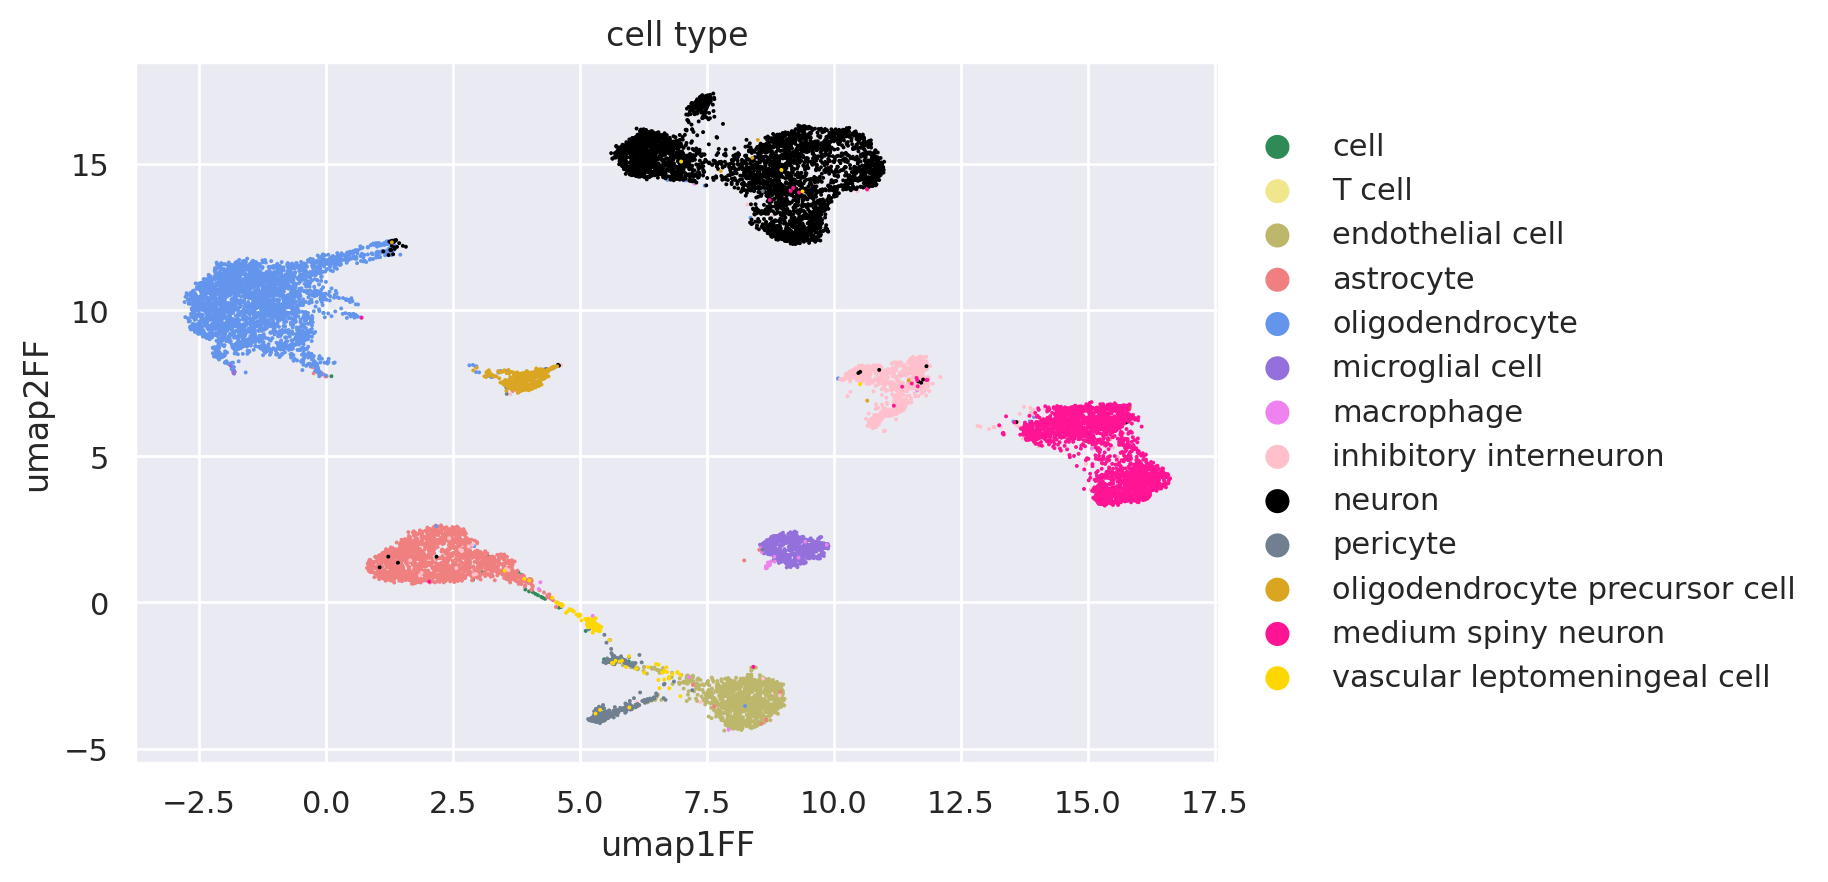

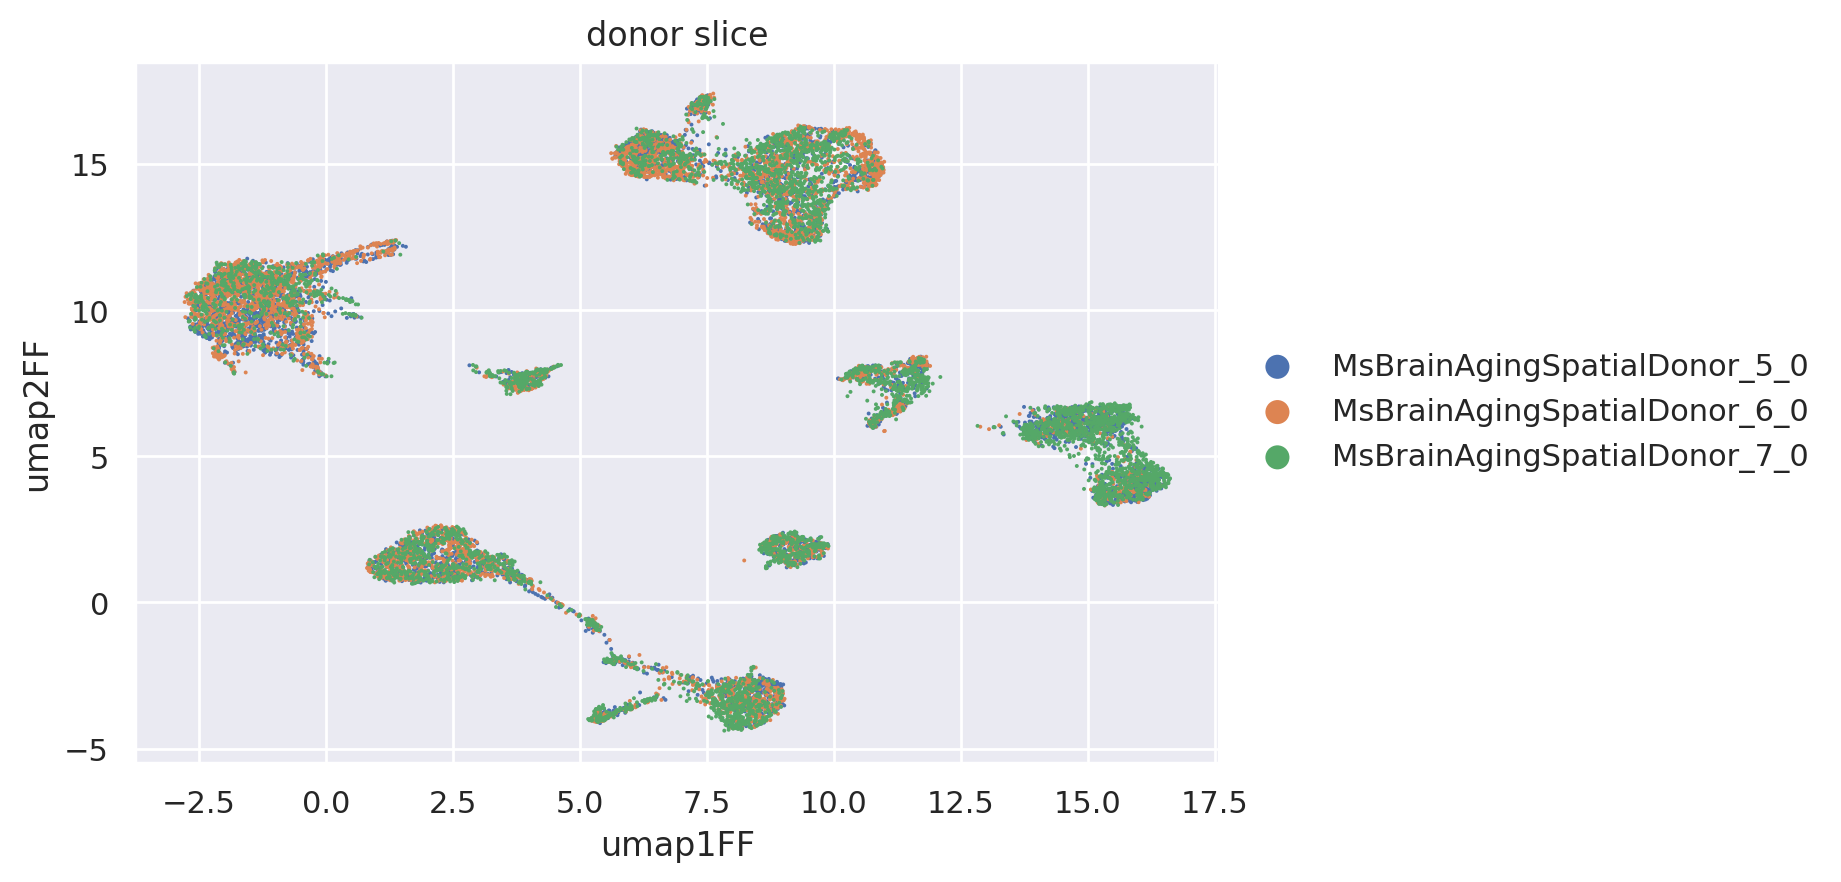

In [56]:
sc.pl.scatter(adataTrain, color='cell_type', x='umap1FF', y='umap2FF')
sc.pl.scatter(adataTrain, color='donor_slice', x='umap1FF', y='umap2FF')


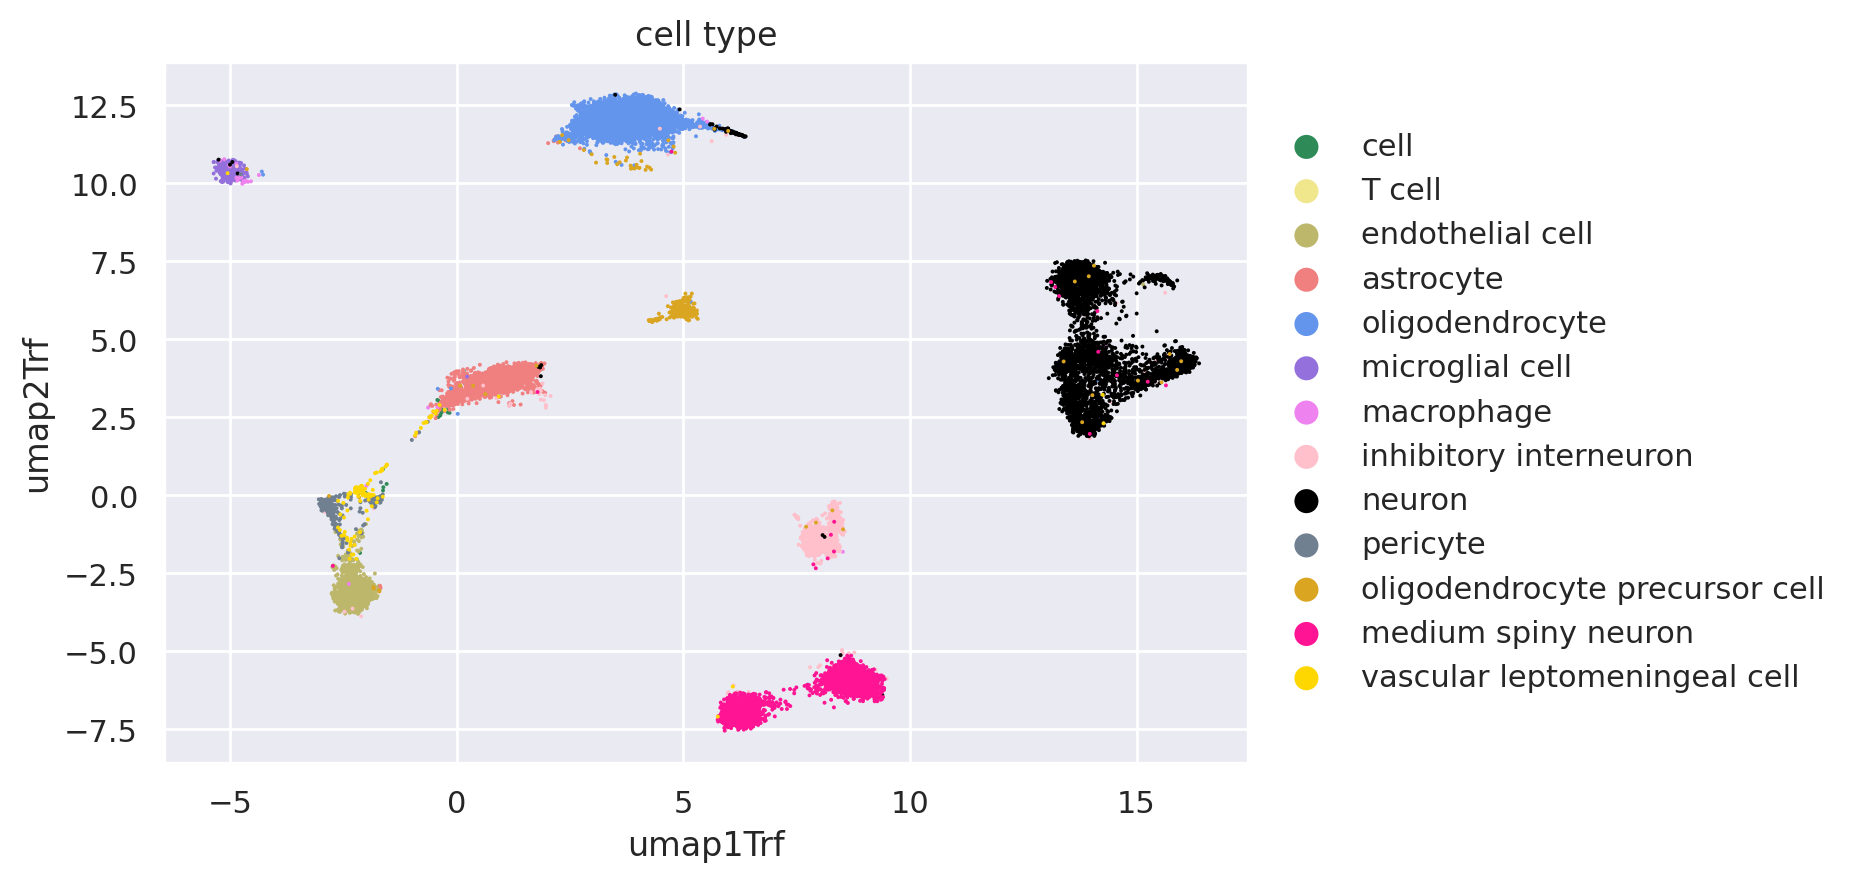

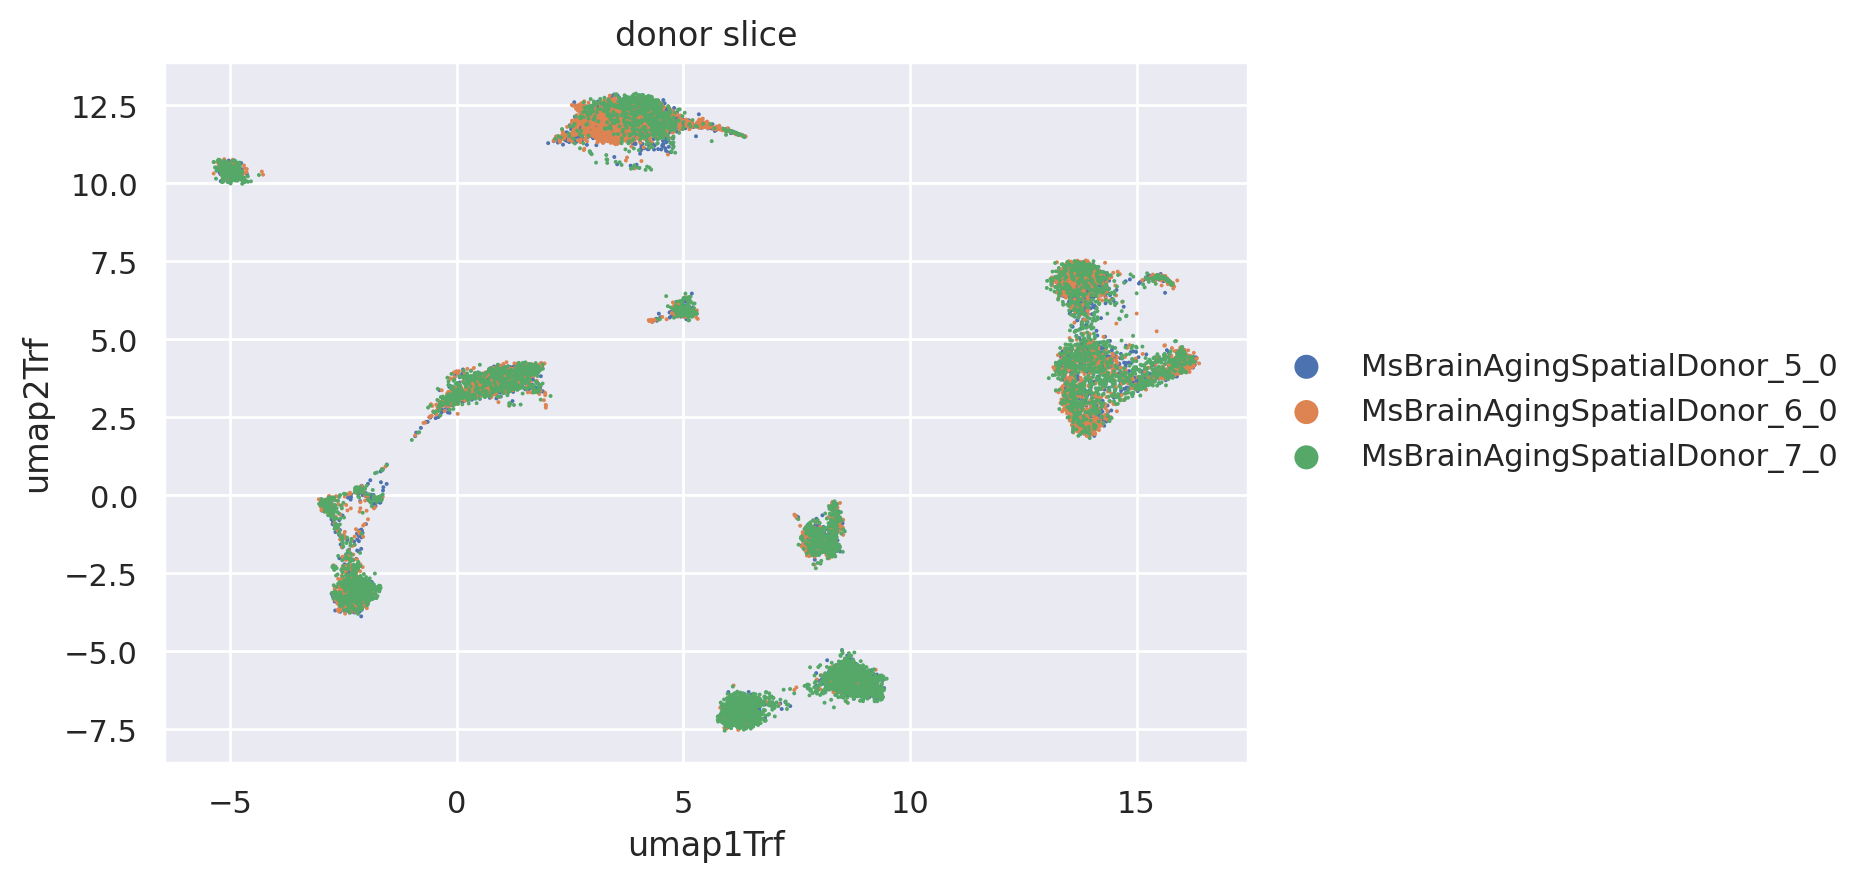

In [57]:
sc.pl.scatter(adataTrain, color='cell_type', x='umap1Trf', y='umap2Trf')
sc.pl.scatter(adataTrain, color='donor_slice', x='umap1Trf', y='umap2Trf')

## Attention Map Decomposition

In [19]:
weight_array

array([[ 9.9987728e-06,  1.2340931e-05,  4.7040908e-06, ...,
        -2.4686877e-05,  1.3168462e-05,  9.5686528e-06],
       [-1.1528769e-05,  1.3223164e-05, -1.5053338e-05, ...,
         5.7355469e-06, -4.2341690e-05,  1.0503324e-05],
       [ 1.7583001e-05, -6.3227399e-06,  9.9557792e-06, ...,
        -6.1396972e-06, -6.2110125e-06, -1.6388191e-06],
       ...,
       [ 1.7672261e-05, -2.4580269e-05, -1.3708685e-05, ...,
         2.5485235e-06,  3.9323506e-05, -2.4073459e-05],
       [ 7.4271734e-06,  9.1375779e-07, -2.3102770e-07, ...,
        -2.8481816e-06,  1.9988538e-05,  2.6785867e-06],
       [ 2.4982288e-05,  1.6644068e-05,  2.3780325e-05, ...,
         7.5519879e-06, -1.0296371e-05, -5.9040945e-06]], dtype=float32)

In [39]:
# do a eigen decomposition of the weight_array

eigVal, eigVec = np.linalg.eig(weight_array)

eigVal, eigVec

(array([-5.80256581e-02,  5.80743216e-02, -5.30018136e-02, -5.16177118e-02,
        -5.04620001e-02, -4.98212054e-02,  5.30221127e-02,  5.13415821e-02,
         4.98497635e-02,  5.04432619e-02, -4.53172140e-02,  4.52931523e-02,
         4.27313410e-02,  4.24113795e-02, -4.24065478e-02, -4.27196100e-02,
         3.74913439e-02, -3.74824665e-02,  3.52869816e-02, -3.52755375e-02,
         3.34231667e-02,  3.22465636e-02,  3.22117098e-02,  3.15090455e-02,
         3.12641039e-02,  3.09604798e-02,  3.04444656e-02,  3.03001627e-02,
         2.89656445e-02,  2.76538692e-02,  2.75803842e-02,  2.71484498e-02,
         2.70032417e-02, -3.34090814e-02, -3.22580747e-02, -3.21515650e-02,
        -3.13743055e-02, -3.12532745e-02, -3.07242628e-02, -3.04182749e-02,
        -2.97205858e-02, -2.89104618e-02, -2.82703098e-02, -2.75546629e-02,
        -2.70003099e-02, -2.71240287e-02, -2.67783478e-02, -2.63843499e-02,
        -2.63709463e-02, -2.58969963e-02, -2.58270185e-02, -2.55640820e-02,
        -2.5

In [40]:
eigVal.shape, eigVec.shape

((374,), (374, 374))

In [43]:
matLbd = -1 / eigVal - 1
matLbd = 0.99 * matLbd / np.max(matLbd)
matLbd = np.diag(matLbd)

G0 = eigVec @ matLbd @ eigVec.T

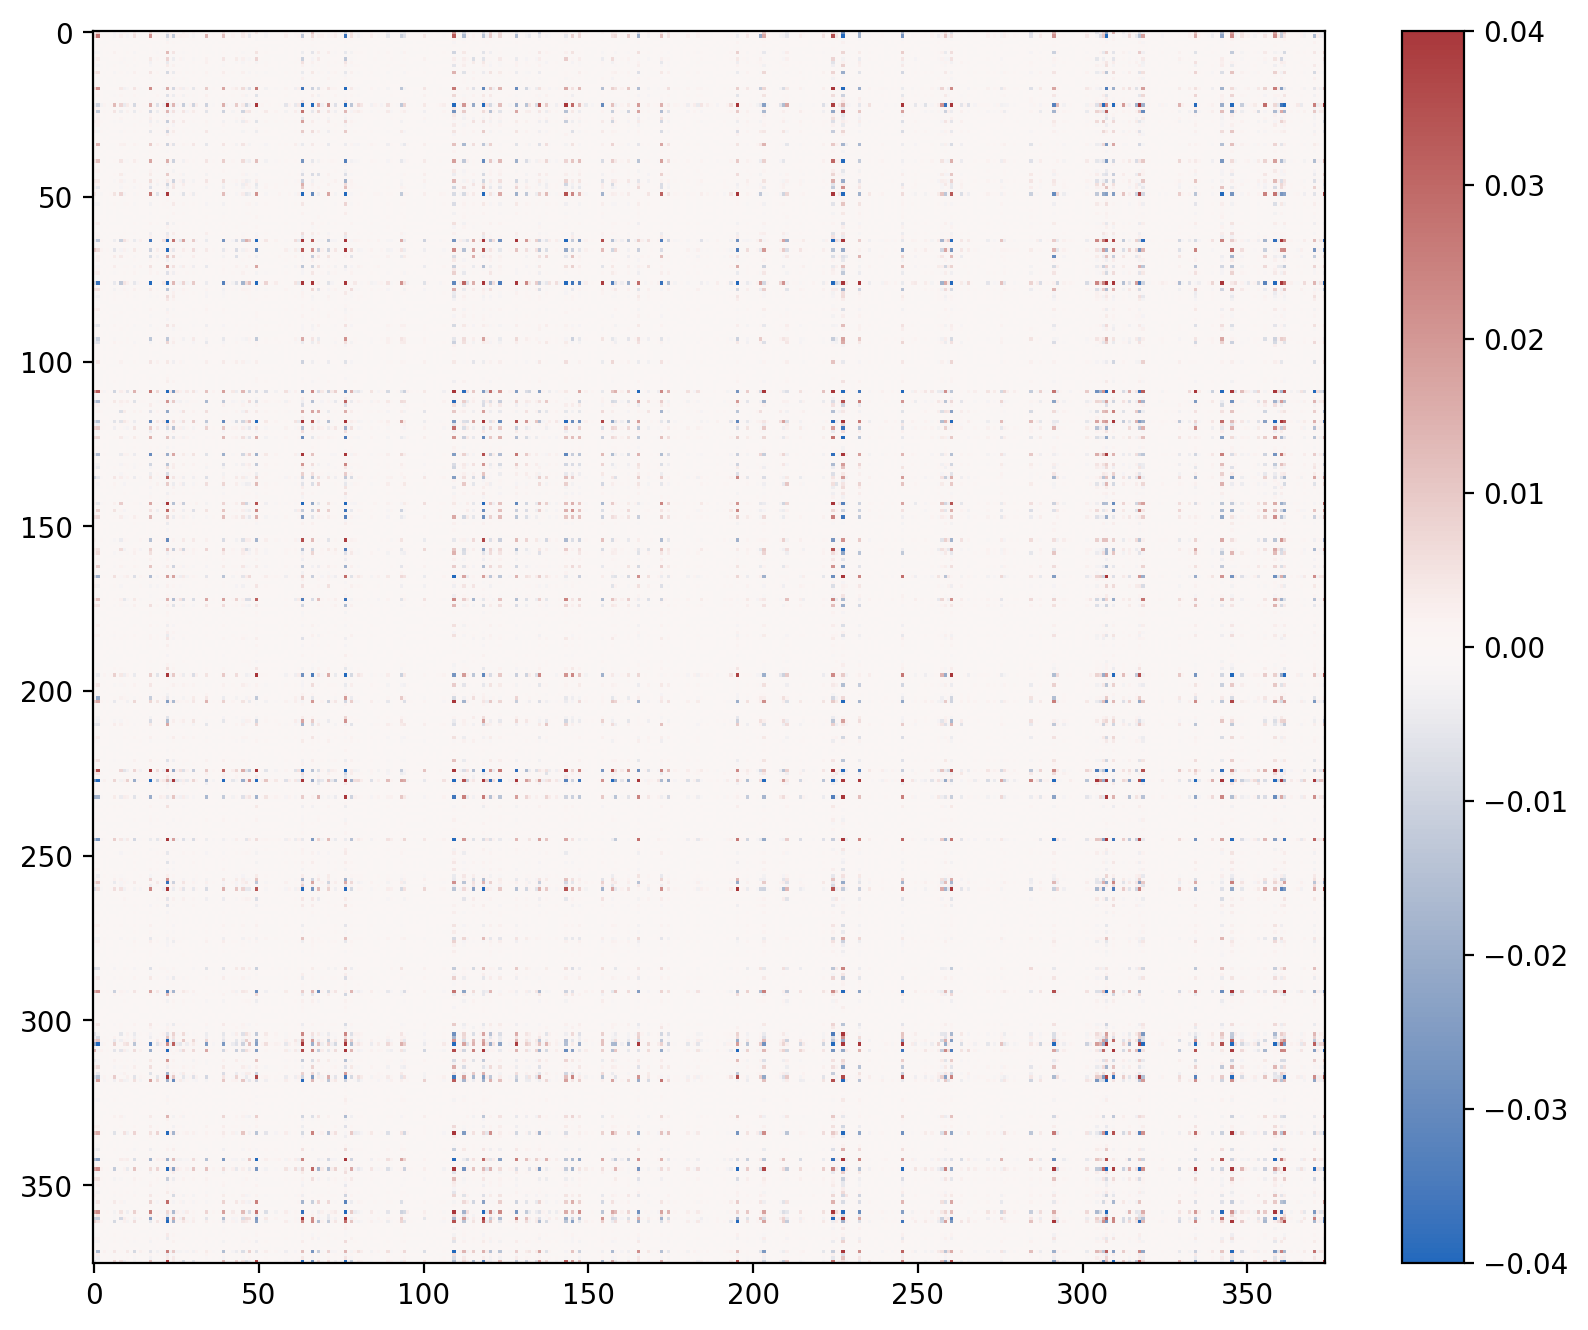

In [44]:
# visualize the G0

plt.figure(figsize=(10, 8))
plt.imshow(G0, cmap='vlag', vmin=-.04, vmax=.04)
plt.colorbar()


In [61]:
import pandas as pd

lr_pairs = pd.read_csv('./mouse_lr_pair.csv')

lgID = lr_pairs['ligand_ensembl_gene_id']
rpID = lr_pairs['receptor_ensembl_gene_id']

relatedGenes = set(lgID) | set(rpID)

relatedGenesIndex = []
for gene in adata.var.index:
    if gene in relatedGenes:
        relatedGenesIndex.append(1)
    else:
        relatedGenesIndex.append(0)

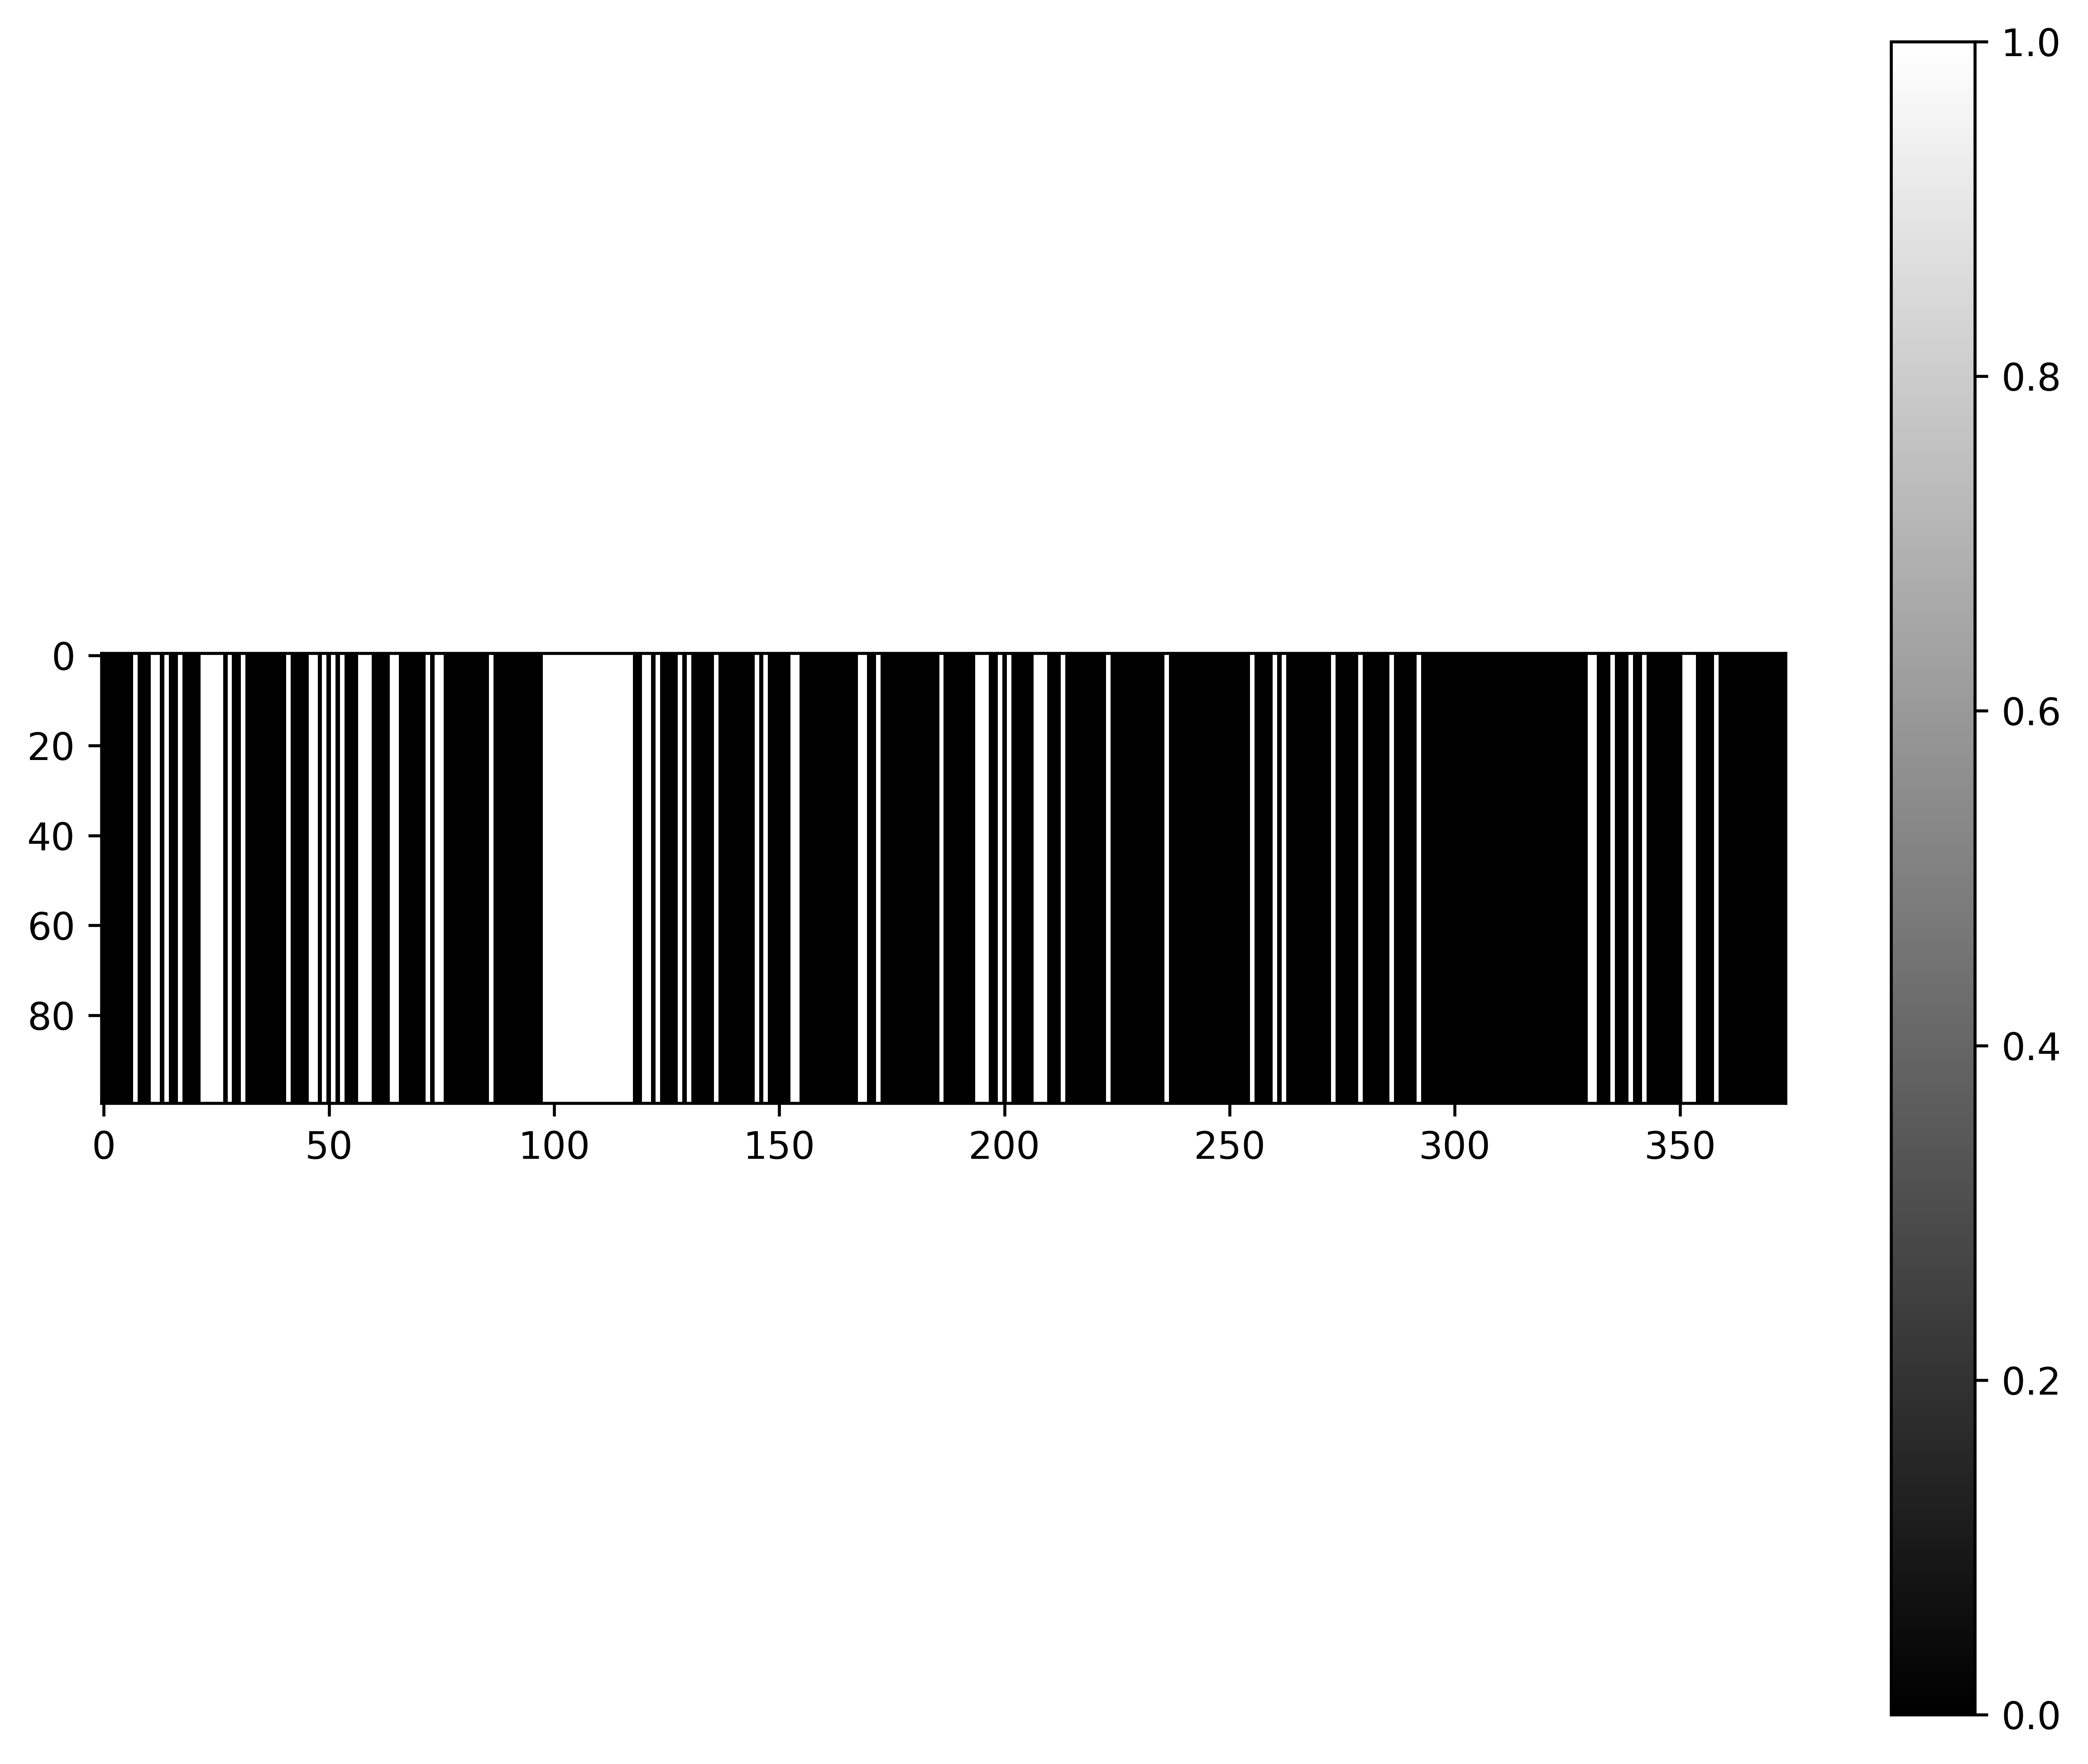

In [62]:
# plot the related genes

relatedGenesIndex = np.array(relatedGenesIndex)[None, :]

relatedGenesIndex = np.repeat(relatedGenesIndex, 100, axis=0)

plt.figure(figsize=(10, 8), dpi=300)
plt.imshow(relatedGenesIndex, cmap='gray')
plt.colorbar()

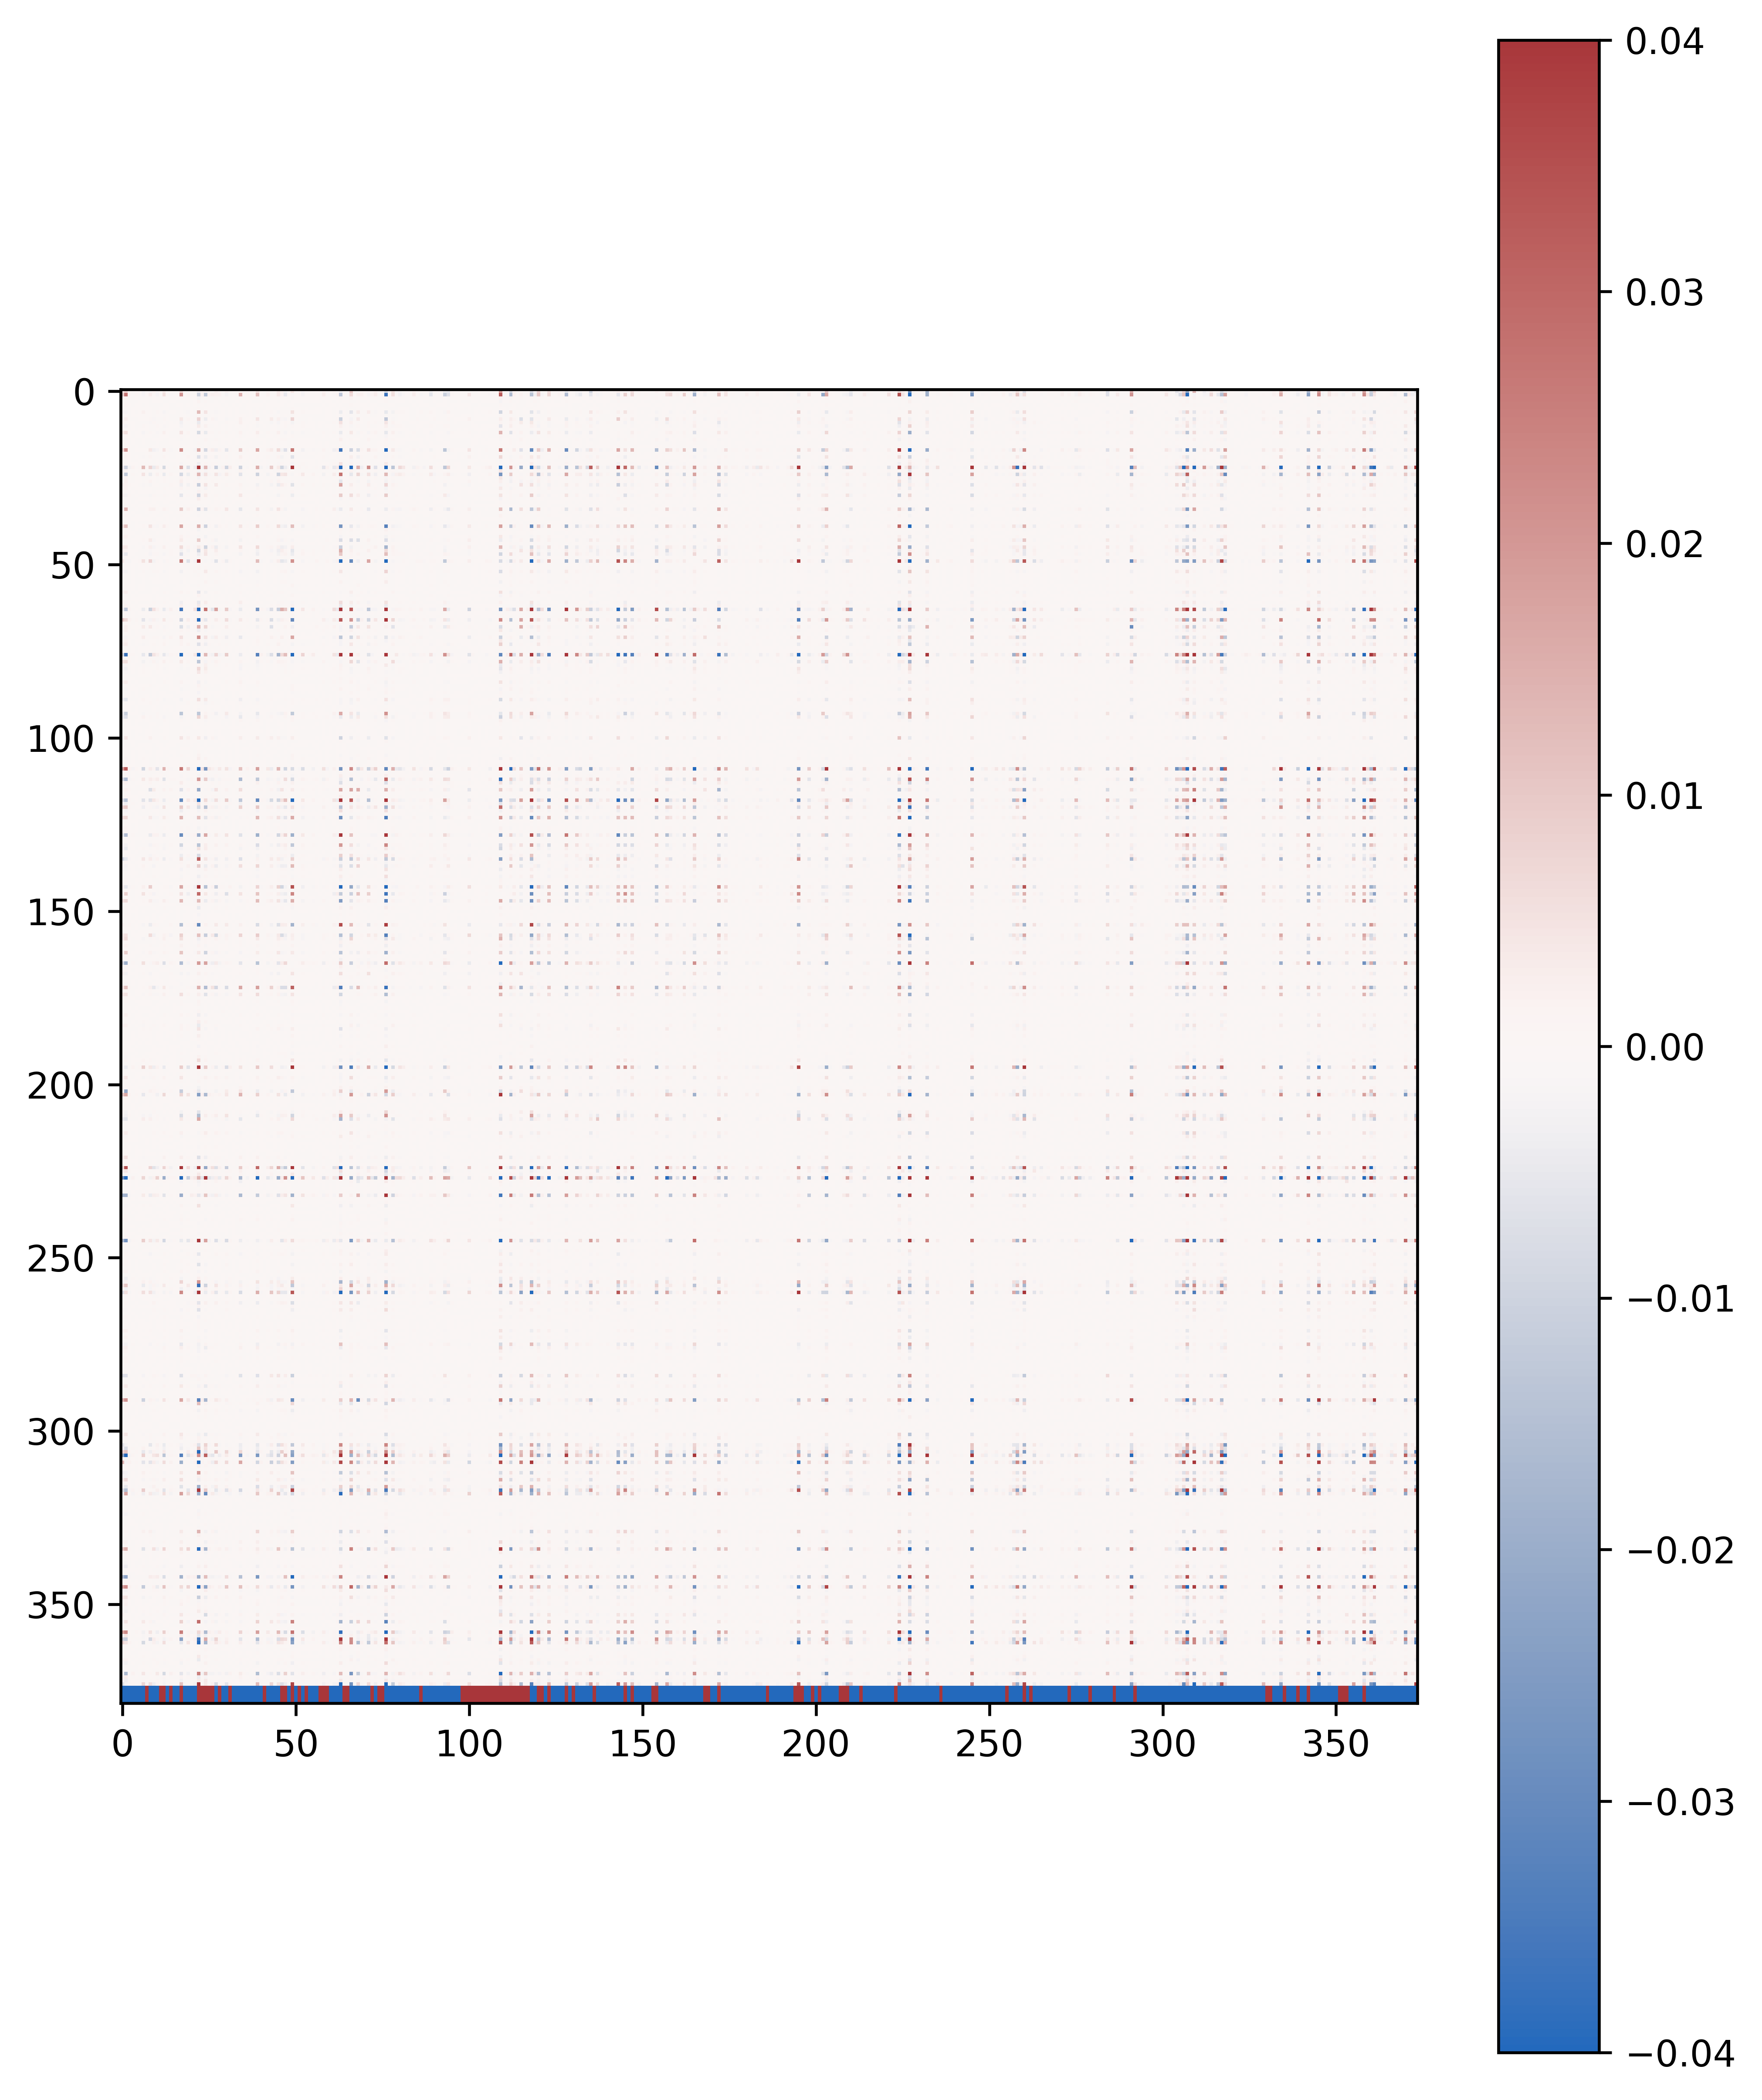

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

matPlot = np.concatenate([G0, relatedGenesIndex[:5, :] * 2 - 1], axis=0)

plt.figure(figsize=(8, 10), dpi=300)
plt.imshow(matPlot, cmap='vlag', vmin=-.04, vmax=.04)
plt.colorbar()
